In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


MULTITASK LSTM BASIC

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam # Add this line to import the Adam
# Split data into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.utils import resample


%load_ext tensorboard

import os
log_dir = os.path.join("logs") # Puedes cambiar "logs" por el nombre que quieras
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Cargar los datos (suponiendo que están en un archivo CSV)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM.csv')

#ARREGLO PARA CALC_IMC NULL
data['CALC_IMC'] = data.groupby('ID')['CALC_IMC'].transform(lambda x: round(x.fillna(x.mean()), 0))
#eliminar filas con datos nulos en IMC
data = data.dropna(subset=['CALC_IMC'])

# Contar registros por ID, ignorando los NaN
#conteo_registros_por_persona = data.groupby('ID')['ID'].count()

# Personas con exactamente 4 registros (sin considerar NaN)
#personas_con_4_registros = conteo_registros_por_persona[conteo_registros_por_persona == 4]
#print(personas_con_4_registros)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv', index=False)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv')

# Normalize numerical variables
columns_to_scale = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION','CIGARRETTES','DRINK','CALC_IMC', 'AGE']
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[columns_to_scale])
#data[columns_to_scale] = scaled_data
data.loc[:, columns_to_scale] = scaled_data

# Convert categorical variables to one-hot encoding
# Crear un objeto OneHotEncoder
columns_to_transform = ['SEX','ALONE','PHYSICAL_ACTIVITY']
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(data[columns_to_transform])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_transform))
data = pd.concat([data, encoded_df], axis=1)

#data = data.drop(columns=['SEX','ALONE','PHYSICAL_ACTIVITY'])

# Agrupar por ID y ordenar por 'Evaluación'
#data_grouped = data.sort_values('evaluacion').groupby('ID')

#data = data.drop(columns=['ID','año','evaluación'])

#data.head()
#print(data.columns)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_ENCODED.csv', index=False)

# Definimos las columnas de las variables a predecir (target)
target_cols = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION']

# Prepare sequences and targets
def create_dataset(data, look_back=3):
  sequences = []
  targets = []
  locomotions = []
  sensories = []
  vitalities = []
  psichologicals = []
  cognitions = []
  auxiliares = []
  for person_id in data['ID'].unique():
    person_data = data[data['ID'] == person_id].sort_values('evaluacion')

     # Get the indices of the relevant columns
    relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY','PSICHOLOGICAL', 'COGNITION',
                        'ALONE_PARTNERED', 'ALONE_UNCOUPLED',
                        'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD','PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                        'CIGARRETTES','DRINK', 'CALC_IMC']
    auxiliar_columns = ['AGE','SEX_FEMALE', 'SEX_MALE']
     # Select the relevant columns first
    person_data_values = person_data[relevant_columns].values
    person_data_auxiliar = person_data[auxiliar_columns].values

    # Create sequences and targets
    if len(person_data_values) < look_back + 1:
        continue
    sequence = person_data_values[:look_back, :]
    target = person_data_values[look_back, data.columns.get_indexer(target_cols)]
    locomotion = person_data_values[look_back, 0]
    sensory = person_data_values[look_back, 1]
    vitality = person_data_values[look_back, 2]
    psichological = person_data_values[look_back, 3]
    cognition = person_data_values[look_back, 4]
    auxiliar = person_data_auxiliar[look_back, :]
    sequences.append(sequence)
    targets.append(target)
    locomotions.append(locomotion)
    sensories.append(sensory)
    vitalities.append(vitality)
    psichologicals.append(psichological)
    cognitions.append(cognition)
    auxiliares.append(auxiliar)
  return np.array(sequences), np.array(targets), np.array(locomotions), np.array(sensories), np.array(vitalities), np.array(psichologicals), np.array(cognitions), np.array(auxiliares)

# Create sequences and targets
look_back = 3
sequences, targets, locomotions, sensories, vitalities, psichologicals, cognitions, auxiliares = create_dataset(data, look_back)

pd.DataFrame(sequences[0]).head()
sequences.shape
sequences.shape[2]

sequences.shape[2]
#pd.DataFrame(targets[0]).head()

auxiliares.shape
auxiliares.shape[1]

targets.shape



# Assuming 'sequences' and 'auxiliares' are your input features,
# and 'locomotions', 'sensories', etc. are your targets
# Split into 80% training and 20% testing
(
    sequences_train,
    sequences_test,
    auxiliares_train,
    auxiliares_test,
    locomotions_train,
    locomotions_test,
    sensories_train,
    sensories_test,
    vitalities_train,
    vitalities_test,
    psichologicals_train,
    psichologicals_test,
    cognitions_train,
    cognitions_test,
) = train_test_split(
    sequences,
    auxiliares,
    locomotions,
    sensories,
    vitalities,
    psichologicals,
    cognitions,
    test_size=0.2,
    random_state=42,  # Optional: for reproducibility
)


# Define input shapes
sequential_input_shape = (sequences.shape[1], sequences.shape[2])  # Adjust num_sequential_features
auxiliary_input_shape = (auxiliares.shape[1],)  # Adjust num_auxiliary_features

# Create the model
def create_model():
    sequential_input = Input(shape=sequential_input_shape, name='sequential_input')
    lstm_output = LSTM(units=24)(sequential_input)  # Adjust LSTM units
    lstm_output = Dropout(0.1)(lstm_output)

    auxiliary_input = Input(shape=auxiliary_input_shape, name='auxiliary_input')

    concatenated_input = Concatenate()([lstm_output, auxiliary_input])

    shared_mlp = Dense(8, activation='tanh')(concatenated_input)  # Adjust hidden units
    shared_mlp = Dropout(0.1)(shared_mlp)

    l_output = Dense(1, activation='linear', name='l_output')(shared_mlp)
    s_output = Dense(1, activation='linear', name='s_output')(shared_mlp)
    v_output = Dense(1, activation='linear', name='v_output')(shared_mlp)
    p_output = Dense(1, activation='linear', name='p_output')(shared_mlp)
    c_output = Dense(1, activation='linear', name='c_output')(shared_mlp)

    model = Model(inputs=[sequential_input, auxiliary_input], outputs=[l_output, s_output, v_output, p_output, c_output ])
    return model

# Compile the model
model = create_model()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss=['mse', 'mse', 'mse', 'mse', 'mse'],
              metrics=[['mse','mae'], ['mse','mae'], ['mse','mae'], ['mse','mae'], ['mse','mae']])  # Adjust loss weights if needed

# Resumen del modelo
model.summary()
keras.utils.plot_model(model, 'modelo.png', show_shapes=True)

# Train the model
model.fit(x=[sequences_train, auxiliares_train], y=[locomotions_train, sensories_train, vitalities_train, psichologicals_train, cognitions_train], epochs=50, batch_size=256, verbose=1, callbacks=[tensorboard_callback])

# Evaluate the model
results = model.evaluate([sequences_test, auxiliares_test],
                        {'l_output': locomotions_test, 's_output': sensories_test, 'v_output': vitalities_test, 'p_output': psichologicals_test, 'c_output': cognitions_test})

# Extract loss and metrics (order should match compilation and evaluation metrics)
loss = results[0]  # Total loss
l_loss = results[1]  # Loss for 'l_output'
s_loss = results[2]  # Loss for 's_output'
v_loss = results[3]  # Loss for 'v_output'
p_loss = results[4]  # Loss for 'p_output'
c_loss = results[5]  # Loss for 'c_output'

# Assuming correct order, retrieve MAE values
l_mae = results[6]  # MAE for 'l_output'
s_mae = results[7]  # MAE for 's_output'
v_mae = results[8]  # MAE for 'v_output'
p_mae = results[9]  # MAE for 'p_output'
c_mae = results[10]  # MAE for 'c_output'


print(f"\nResultados de la evaluación:\n"
      f"Pérdida total: {loss:.4f}\n"
      f"Pérdida para l (Regresión): {l_loss:.4f}\n"
      f"Pérdida para s (Regresión): {s_loss:.4f}\n"
      f"Pérdida para v (Regresión): {v_loss:.4f}\n"
      f"Pérdida para p (Regresión): {p_loss:.4f}\n"
      f"Pérdida para c (Regresión): {c_loss:.4f}\n"
      f"MAE para l (Regresión): {l_mae:.4f}\n"
     f"MAE para s (Regresión): {s_mae:.4f}\n"
    f"MAE para v (Regresión): {v_mae:.4f}\n"
     f"MAE para p (Regresión): {p_mae:.4f}\n"
     f"MAE para c (Regresión): {c_mae:.4f}"
      )

#%tensorboard --logdir logs

model.save('/content/drive/My Drive/PREDICTIVE MODEL IC/mi_modelo.keras')

!pip install netron
import netron
netron.start('/content/drive/My Drive/PREDICTIVE MODEL IC/mi_modelo.keras')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<ipython-input-3-17cbdd40d1bd>:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.         0.81818182 0.90909091 ... 0.72727273 0.54545455 0.81818182]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data
<ipython-input-3-17cbdd40d1bd>:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.61428571 0.65714286 0.71428571 ... 0.32857143 0.38571429 0.44285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sequential_input          │ (None, 3, 14)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 24)             │          3,744 │ sequential_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 24)             │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ auxiliary_input           │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 27)             │              0 │ dropout[0][0],         │
│                           │                        │                │ auxiliary_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 8)              │            224 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 8)              │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l_output (Dense)          │ (None, 1)              │              9 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ s_output (Dense)          │ (None, 1)              │              9 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ v_output (Dense)          │ (None, 1)              │              9 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ p_output (Dense)          │ (None, 1)              │              9 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ c_output (Dense)          │ (None, 1)              │              9 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,013 (15.68 KB)

 Trainable params: 4,013 (15.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - c_output_loss: 0.9086 - c_output_mae: 0.8122 - c_output_mse: 0.9109 - l_output_loss: 0.5616 - l_output_mae: 0.6675 - l_output_mse: 0.5624 - loss: 4.0403 - p_output_loss: 0.8901 - p_output_mae: 0.9220 - p_output_mse: 0.8908 - s_output_loss: 0.9648 - s_output_mae: 0.9570 - s_output_mse: 0.9674 - v_output_loss: 0.7053 - v_output_mae: 0.7592 - v_output_mse: 0.7087
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - c_output_loss: 0.5723 - c_output_mae: 0.6125 - c_output_mse: 0.5740 - l_output_loss: 0.5707 - l_output_mae: 0.6766 - l_output_mse: 0.5708 - loss: 3.1163 - p_output_loss: 0.8715 - p_output_mae: 0.9104 - p_output_mse: 0.8713 - s_output_loss: 0.7112 - s_output_mae: 0.8140 - s_output_mse: 0.7132 - v_output_loss: 0.3857 - v_output_mae: 0.5270 - v_output_mse: 0.3869 
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - c_output_loss: 0.3384 - c_output_mae: 0.4470 - c_output_mse: 0.3402 - l_output_loss: 0.5274 - l_output_mae: 0.6530 - l_o

('localhost', 8081)

In [ ]:
!pip install scikit-learn --upgrade

LSTM MULTITASKING IC 95%

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam # Add this line to import the Adam
# Split data into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import mean_absolute_error # Import the mean_absolute_error function


%load_ext tensorboard

import os
log_dir = os.path.join("logs") # Puedes cambiar "logs" por el nombre que quieras
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Cargar los datos (suponiendo que están en un archivo CSV)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM.csv')

#ARREGLO PARA CALC_IMC NULL
data['CALC_IMC'] = data.groupby('ID')['CALC_IMC'].transform(lambda x: round(x.fillna(x.mean()), 0))
#eliminar filas con datos nulos en IMC
data = data.dropna(subset=['CALC_IMC'])

# Contar registros por ID, ignorando los NaN
#conteo_registros_por_persona = data.groupby('ID')['ID'].count()

# Personas con exactamente 4 registros (sin considerar NaN)
#personas_con_4_registros = conteo_registros_por_persona[conteo_registros_por_persona == 4]
#print(personas_con_4_registros)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv', index=False)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv')

# Normalize numerical variables
columns_to_scale = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION','CIGARRETTES','DRINK','CALC_IMC', 'AGE']
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[columns_to_scale])
#data[columns_to_scale] = scaled_data
data.loc[:, columns_to_scale] = scaled_data

# Convert categorical variables to one-hot encoding
# Crear un objeto OneHotEncoder
columns_to_transform = ['SEX','ALONE','PHYSICAL_ACTIVITY']
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(data[columns_to_transform])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_transform))
data = pd.concat([data, encoded_df], axis=1)

#data = data.drop(columns=['SEX','ALONE','PHYSICAL_ACTIVITY'])

# Agrupar por ID y ordenar por 'Evaluación'
#data_grouped = data.sort_values('evaluacion').groupby('ID')

#data = data.drop(columns=['ID','año','evaluación'])

#data.head()
#print(data.columns)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_ENCODED.csv', index=False)

# Definimos las columnas de las variables a predecir (target)
target_cols = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION']

# Prepare sequences and targets
def create_dataset(data, look_back=3):
  sequences = []
  targets = []
  locomotions = []
  sensories = []
  vitalities = []
  psichologicals = []
  cognitions = []
  auxiliares = []
  for person_id in data['ID'].unique():
    person_data = data[data['ID'] == person_id].sort_values('evaluacion')

     # Get the indices of the relevant columns
    relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY','PSICHOLOGICAL', 'COGNITION',
                        'ALONE_PARTNERED', 'ALONE_UNCOUPLED',
                        'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD','PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                        'CIGARRETTES','DRINK', 'CALC_IMC']
    auxiliar_columns = ['AGE','SEX_FEMALE', 'SEX_MALE']
     # Select the relevant columns first
    person_data_values = person_data[relevant_columns].values
    person_data_auxiliar = person_data[auxiliar_columns].values

    # Create sequences and targets
    if len(person_data_values) < look_back + 1:
        continue
    sequence = person_data_values[:look_back, :]
    target = person_data_values[look_back, data.columns.get_indexer(target_cols)]
    locomotion = person_data_values[look_back, 0]
    sensory = person_data_values[look_back, 1]
    vitality = person_data_values[look_back, 2]
    psichological = person_data_values[look_back, 3]
    cognition = person_data_values[look_back, 4]
    auxiliar = person_data_auxiliar[look_back, :]
    sequences.append(sequence)
    targets.append(target)
    locomotions.append(locomotion)
    sensories.append(sensory)
    vitalities.append(vitality)
    psichologicals.append(psichological)
    cognitions.append(cognition)
    auxiliares.append(auxiliar)
  return np.array(sequences), np.array(targets), np.array(locomotions), np.array(sensories), np.array(vitalities), np.array(psichologicals), np.array(cognitions), np.array(auxiliares)

# Create sequences and targets
look_back = 3
sequences, targets, locomotions, sensories, vitalities, psichologicals, cognitions, auxiliares = create_dataset(data, look_back)

pd.DataFrame(sequences[0]).head()
sequences.shape
sequences.shape[2]

sequences.shape[2]
#pd.DataFrame(targets[0]).head()

auxiliares.shape
auxiliares.shape[1]

targets.shape

# TRAINNING AND TEST

# Assuming 'sequences' and 'auxiliares' are your input features,
# and 'locomotions', 'sensories', etc. are your targets
# Split into 80% training and 20% testing
(
    sequences_train,
    sequences_test,
    auxiliares_train,
    auxiliares_test,
    locomotions_train,
    locomotions_test,
    sensories_train,
    sensories_test,
    vitalities_train,
    vitalities_test,
    psichologicals_train,
    psichologicals_test,
    cognitions_train,
    cognitions_test,
) = train_test_split(
    sequences,
    auxiliares,
    locomotions,
    sensories,
    vitalities,
    psichologicals,
    cognitions,
    test_size=0.2,
    random_state=42,  # Optional: for reproducibility
)


# Define input shapes
sequential_input_shape = (sequences.shape[1], sequences.shape[2])  # Adjust num_sequential_features
auxiliary_input_shape = (auxiliares.shape[1],)  # Adjust num_auxiliary_features

# Create the model
def create_model():
    sequential_input = Input(shape=sequential_input_shape, name='sequential_input')
    lstm_output = LSTM(units=24)(sequential_input)  # Adjust LSTM units
    lstm_output = Dropout(0.1)(lstm_output)

    auxiliary_input = Input(shape=auxiliary_input_shape, name='auxiliary_input')

    concatenated_input = Concatenate()([lstm_output, auxiliary_input])

    shared_mlp = Dense(8, activation='tanh')(concatenated_input)  # Adjust hidden units
    shared_mlp = Dropout(0.1)(shared_mlp)

    l_output = Dense(1, activation='linear', name='l_output')(shared_mlp)
    s_output = Dense(1, activation='linear', name='s_output')(shared_mlp)
    v_output = Dense(1, activation='linear', name='v_output')(shared_mlp)
    p_output = Dense(1, activation='linear', name='p_output')(shared_mlp)
    c_output = Dense(1, activation='linear', name='c_output')(shared_mlp)

    model = Model(inputs=[sequential_input, auxiliary_input], outputs=[l_output, s_output, v_output, p_output, c_output ])
    return model

# Compile the model
model = create_model()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss=['mse', 'mse', 'mse', 'mse', 'mse'],
              metrics=[['mse','mae'], ['mse','mae'], ['mse','mae'], ['mse','mae'], ['mse','mae']])  # Adjust loss weights if needed

# Resumen del modelo
model.summary()
keras.utils.plot_model(model, 'modelo.png', show_shapes=True)

# Train the model
model.fit(x=[sequences_train, auxiliares_train], y=[locomotions_train, sensories_train, vitalities_train, psichologicals_train, cognitions_train], epochs=50, batch_size=256, verbose=1, callbacks=[tensorboard_callback])

# Evaluate the model
results = model.evaluate([sequences_test, auxiliares_test],
                        {'l_output': locomotions_test, 's_output': sensories_test, 'v_output': vitalities_test, 'p_output': psichologicals_test, 'c_output': cognitions_test})


# Extract loss and metrics (order should match compilation and evaluation metrics)
loss = results[0]  # Total loss
l_loss = results[1]  # Loss for 'l_output'
s_loss = results[2]  # Loss for 's_output'
v_loss = results[3]  # Loss for 'v_output'
p_loss = results[4]  # Loss for 'p_output'
c_loss = results[5]  # Loss for 'c_output'

# Assuming correct order, retrieve MAE values
l_mae = results[6]  # MAE for 'l_output'
s_mae = results[7]  # MAE for 's_output'
v_mae = results[8]  # MAE for 'v_output'
p_mae = results[9]  # MAE for 'p_output'
c_mae = results[10]  # MAE for 'c_output'


print(f"\nResultados de la evaluación ORIGINAL:\n"
      f"Pérdida total: {loss:.4f}\n"
      f"Pérdida para l (Regresión): {l_loss:.4f}\n"
      f"Pérdida para s (Regresión): {s_loss:.4f}\n"
      f"Pérdida para v (Regresión): {v_loss:.4f}\n"
      f"Pérdida para p (Regresión): {p_loss:.4f}\n"
      f"Pérdida para c (Regresión): {c_loss:.4f}\n"
      f"MAE para l (Regresión): {l_mae:.4f}\n"
     f"MAE para s (Regresión): {s_mae:.4f}\n"
    f"MAE para v (Regresión): {v_mae:.4f}\n"
     f"MAE para p (Regresión): {p_mae:.4f}\n"
     f"MAE para c (Regresión): {c_mae:.4f}"
      )


# Función para calcular MAE con intervalo de confianza usando Bootstrap (CÓDIGO NUEVO)
def calcular_mae_intervalo_confianza(
    sequences_train, auxiliares_train, locomotions_train, sensories_train, vitalities_train, psichologicals_train, cognitions_train,
    sequences_test, auxiliares_test, locomotions_test, sensories_test, vitalities_test, psichologicals_test, cognitions_test,
    num_ejecuciones=1000
):
    l_maes = []
    s_maes = []
    v_maes = []
    p_maes = []
    c_maes = []

    for _ in range(num_ejecuciones):
        indices_bootstrap = resample(np.arange(len(sequences_test)), replace=True, n_samples=len(sequences_test))

        sequences_bootstrap = sequences_test[indices_bootstrap]
        auxiliares_bootstrap = auxiliares_test[indices_bootstrap]
        locomotions_bootstrap = locomotions_test[indices_bootstrap]
        sensories_bootstrap = sensories_test[indices_bootstrap]
        vitalities_bootstrap = vitalities_test[indices_bootstrap]
        psichologicals_bootstrap = psichologicals_test[indices_bootstrap]
        cognitions_bootstrap = cognitions_test[indices_bootstrap]

        # 2. Evaluate the model on the bootstrap sample (no training in each iteration)
        #predictions = model.predict([sequences_bootstrap, auxiliares_bootstrap])

         # Evaluate the model on the bootstrap sample
        results1 = model.evaluate(
        [sequences_bootstrap, auxiliares_bootstrap],
        [locomotions_bootstrap, sensories_bootstrap, vitalities_bootstrap, psichologicals_bootstrap, cognitions_bootstrap],
        verbose=0  # Set verbose to 0 to suppress output during evaluation
        )

        # Extract MAE values from the results
        l_mae = results1[6]  # MAE for 'l_output' (assuming the correct index)
        s_mae = results1[7]  # MAE for 's_output'
        v_mae = results1[8]  # MAE for 'v_output'
        p_mae = results1[9]  # MAE for 'p_output'
        c_mae = results1[10]  # MAE for 'c_output'

        # Calcula el MAE para cada variable objetivo usando las predicciones (CÓDIGO NUEVO)
       # l_mae = mean_absolute_error(locomotions_bootstrap, predictions[0])
        #s_mae = mean_absolute_error(sensories_bootstrap, predictions[1])
        #v_mae = mean_absolute_error(vitalities_bootstrap, predictions[2])
        #p_mae = mean_absolute_error(psichologicals_bootstrap, predictions[3])
        #c_mae = mean_absolute_error(cognitions_bootstrap, predictions[4])

        l_maes.append(l_mae)
        s_maes.append(s_mae)
        v_maes.append(v_mae)
        p_maes.append(p_mae)
        c_maes.append(c_mae)

    # Función para calcular estadísticas e intervalos de confianza (CÓDIGO NUEVO)
    def calculate_ci(maes):
        mae_promedio = np.mean(maes)
        desviacion_estandar = np.std(maes)
        valor_critico = 1.96  # Para un intervalo de confianza del 95%
        margen_de_error = valor_critico * (desviacion_estandar / np.sqrt(num_ejecuciones))
        limite_inferior = mae_promedio - margen_de_error
        limite_superior = mae_promedio + margen_de_error
        return mae_promedio, (limite_inferior, limite_superior)

    l_results = calculate_ci(l_maes)
    s_results = calculate_ci(s_maes)
    v_results = calculate_ci(v_maes)
    p_results = calculate_ci(p_maes)
    c_results = calculate_ci(c_maes)

    return {
        'l': l_results,
        's': s_results,
        'v': v_results,
        'p': p_results,
        'c': c_results,
    }

# Calcula intervalo de confianza con Bootstrap (CÓDIGO NUEVO)
resultados_bootstrap = calcular_mae_intervalo_confianza(
    sequences_train, auxiliares_train, locomotions_train, sensories_train, vitalities_train, psichologicals_train, cognitions_train,
    sequences_test, auxiliares_test, locomotions_test, sensories_test, vitalities_test, psichologicals_test, cognitions_test,
    num_ejecuciones=1000
)

# Imprime los resultados del Bootstrap (CÓDIGO NUEVO)
for target, (mae_promedio, intervalo_confianza) in resultados_bootstrap.items():
    print(f"MAE para {target} (Regresión): {mae_promedio:.4f} (IC 95%: {intervalo_confianza})")


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<ipython-input-4-f99d03bc0863>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.         0.81818182 0.90909091 ... 0.72727273 0.54545455 0.81818182]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data
<ipython-input-4-f99d03bc0863>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.61428571 0.65714286 0.71428571 ... 0.32857143 0.38571429 0.44285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sequential_input          │ (None, 3, 14)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 24)             │          3,744 │ sequential_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 24)             │              0 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ auxiliary_input           │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 27)             │              0 │ dropout_4[0][0],       │
│ (Concatenate)             │                        │                │ auxiliary_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8)              │            224 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 8)              │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l_output (Dense)          │ (None, 1)              │              9 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ s_output (Dense)          │ (None, 1)              │              9 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ v_output (Dense)          │ (None, 1)              │              9 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ p_output (Dense)          │ (None, 1)              │              9 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ c_output (Dense)          │ (None, 1)              │              9 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,013 (15.68 KB)

 Trainable params: 4,013 (15.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - c_output_loss: 1.3885 - c_output_mae: 1.1572 - c_output_mse: 1.3879 - l_output_loss: 0.4897 - l_output_mae: 0.6272 - l_output_mse: 0.4916 - loss: 4.7833 - p_output_loss: 0.4853 - p_output_mae: 0.6725 - p_output_mse: 0.4869 - s_output_loss: 0.9447 - s_output_mae: 0.9106 - s_output_mse: 0.9476 - v_output_loss: 1.4657 - v_output_mae: 1.1889 - v_output_mse: 1.4692
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - c_output_loss: 1.3308 - c_output_mae: 1.1312 - c_output_mse: 1.3310 - l_output_loss: 0.3006 - l_output_mae: 0.4803 - l_output_mse: 0.3010 - loss: 3.5745 - p_output_loss: 0.3478 - p_output_mae: 0.5647 - p_output_mse: 0.3489 - s_output_loss: 0.5179 - s_output_mae: 0.6437 - s_output_mse: 0.5192 - v_output_loss: 1.0739 - v_output_mae: 1.0138 - v_output_mse: 1.0743
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - c_output_loss: 1.2108 - c_output_mae: 1.0760 - c_output_mse: 1.2136 - l_output_loss: 0.2215 - l_output_mae: 0.4000 - l_ou

Multitask LSTM
(without auxiliary
variables)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam # Add this line to import the Adam
# Split data into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import mean_absolute_error # Import the mean_absolute_error function


%load_ext tensorboard

import os
log_dir = os.path.join("logs") # Puedes cambiar "logs" por el nombre que quieras
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Cargar los datos (suponiendo que están en un archivo CSV)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM.csv')

#ARREGLO PARA CALC_IMC NULL
data['CALC_IMC'] = data.groupby('ID')['CALC_IMC'].transform(lambda x: round(x.fillna(x.mean()), 0))
#eliminar filas con datos nulos en IMC
data = data.dropna(subset=['CALC_IMC'])

# Contar registros por ID, ignorando los NaN
#conteo_registros_por_persona = data.groupby('ID')['ID'].count()

# Personas con exactamente 4 registros (sin considerar NaN)
#personas_con_4_registros = conteo_registros_por_persona[conteo_registros_por_persona == 4]
#print(personas_con_4_registros)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv', index=False)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv')

# Normalize numerical variables
columns_to_scale = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION','CIGARRETTES','DRINK','CALC_IMC', 'AGE']
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[columns_to_scale])
#data[columns_to_scale] = scaled_data
data.loc[:, columns_to_scale] = scaled_data

# Convert categorical variables to one-hot encoding
# Crear un objeto OneHotEncoder
columns_to_transform = ['SEX','ALONE','PHYSICAL_ACTIVITY']
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(data[columns_to_transform])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_transform))
data = pd.concat([data, encoded_df], axis=1)

#data = data.drop(columns=['SEX','ALONE','PHYSICAL_ACTIVITY'])

# Agrupar por ID y ordenar por 'Evaluación'
#data_grouped = data.sort_values('evaluacion').groupby('ID')

#data = data.drop(columns=['ID','año','evaluación'])

#data.head()
#print(data.columns)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_ENCODED.csv', index=False)

# Definimos las columnas de las variables a predecir (target)
target_cols = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION']

# Prepare sequences and targets
def create_dataset(data, look_back=3):
  sequences = []
  targets = []
  locomotions = []
  sensories = []
  vitalities = []
  psichologicals = []
  cognitions = []
  auxiliares = []
  for person_id in data['ID'].unique():
    person_data = data[data['ID'] == person_id].sort_values('evaluacion')

     # Get the indices of the relevant columns
    relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY','PSICHOLOGICAL', 'COGNITION',
                        'ALONE_PARTNERED', 'ALONE_UNCOUPLED',
                        'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD','PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                        'CIGARRETTES','DRINK', 'CALC_IMC']
    auxiliar_columns = ['AGE','SEX_FEMALE', 'SEX_MALE']
     # Select the relevant columns first
    person_data_values = person_data[relevant_columns].values
    person_data_auxiliar = person_data[auxiliar_columns].values

    # Create sequences and targets
    if len(person_data_values) < look_back + 1:
        continue
    sequence = person_data_values[:look_back, :]
    target = person_data_values[look_back, data.columns.get_indexer(target_cols)]
    locomotion = person_data_values[look_back, 0]
    sensory = person_data_values[look_back, 1]
    vitality = person_data_values[look_back, 2]
    psichological = person_data_values[look_back, 3]
    cognition = person_data_values[look_back, 4]
    auxiliar = person_data_auxiliar[look_back, :]
    sequences.append(sequence)
    targets.append(target)
    locomotions.append(locomotion)
    sensories.append(sensory)
    vitalities.append(vitality)
    psichologicals.append(psichological)
    cognitions.append(cognition)
    auxiliares.append(auxiliar)
  return np.array(sequences), np.array(targets), np.array(locomotions), np.array(sensories), np.array(vitalities), np.array(psichologicals), np.array(cognitions), np.array(auxiliares)

# Create sequences and targets
look_back = 3
sequences, targets, locomotions, sensories, vitalities, psichologicals, cognitions, auxiliares = create_dataset(data, look_back)

pd.DataFrame(sequences[0]).head()
sequences.shape
sequences.shape[2]

sequences.shape[2]
#pd.DataFrame(targets[0]).head()

auxiliares.shape
auxiliares.shape[1]

targets.shape

# TRAINNING AND TEST

# Assuming 'sequences' and 'auxiliares' are your input features,
# and 'locomotions', 'sensories', etc. are your targets
# Split into 80% training and 20% testing
(
    sequences_train,
    sequences_test,
    auxiliares_train,
    auxiliares_test,
    locomotions_train,
    locomotions_test,
    sensories_train,
    sensories_test,
    vitalities_train,
    vitalities_test,
    psichologicals_train,
    psichologicals_test,
    cognitions_train,
    cognitions_test,
) = train_test_split(
    sequences,
    auxiliares,
    locomotions,
    sensories,
    vitalities,
    psichologicals,
    cognitions,
    test_size=0.2,
    random_state=42,  # Optional: for reproducibility
)


# Define input shapes
sequential_input_shape = (sequences.shape[1], sequences.shape[2])  # Adjust num_sequential_features
auxiliary_input_shape = (auxiliares.shape[1],)  # Adjust num_auxiliary_features

# Create the model
def create_model():
    sequential_input = Input(shape=sequential_input_shape, name='sequential_input')
    lstm_output = LSTM(units=24)(sequential_input)  # Adjust LSTM units
    lstm_output = Dropout(0.1)(lstm_output)

    auxiliary_input = Input(shape=auxiliary_input_shape, name='auxiliary_input')

    concatenated_input = Concatenate()([lstm_output, auxiliary_input])

    #shared_mlp = Dense(8, activation='tanh')(concatenated_input)  # Adjust hidden units
    #shared_mlp = Dropout(0.1)(shared_mlp)

    l_output = Dense(1, activation='linear', name='l_output')(lstm_output)
    s_output = Dense(1, activation='linear', name='s_output')(lstm_output)
    v_output = Dense(1, activation='linear', name='v_output')(lstm_output)
    p_output = Dense(1, activation='linear', name='p_output')(lstm_output)
    c_output = Dense(1, activation='linear', name='c_output')(lstm_output)

    model = Model(inputs=[sequential_input], outputs=[l_output, s_output, v_output, p_output, c_output ])
    return model

# Compile the model
model = create_model()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss=['mse', 'mse', 'mse', 'mse', 'mse'],
              metrics=[['mse','mae'], ['mse','mae'], ['mse','mae'], ['mse','mae'], ['mse','mae']])  # Adjust loss weights if needed

# Resumen del modelo
model.summary()
keras.utils.plot_model(model, 'modelo.png', show_shapes=True)

# Train the model
model.fit(x=[sequences_train], y=[locomotions_train, sensories_train, vitalities_train, psichologicals_train, cognitions_train], epochs=50, batch_size=256, verbose=1, callbacks=[tensorboard_callback])

# Evaluate the model
results = model.evaluate([sequences_test],
                        {'l_output': locomotions_test, 's_output': sensories_test, 'v_output': vitalities_test, 'p_output': psichologicals_test, 'c_output': cognitions_test})


# Extract loss and metrics (order should match compilation and evaluation metrics)
loss = results[0]  # Total loss
l_loss = results[1]  # Loss for 'l_output'
s_loss = results[2]  # Loss for 's_output'
v_loss = results[3]  # Loss for 'v_output'
p_loss = results[4]  # Loss for 'p_output'
c_loss = results[5]  # Loss for 'c_output'

# Assuming correct order, retrieve MAE values
l_mae = results[6]  # MAE for 'l_output'
s_mae = results[7]  # MAE for 's_output'
v_mae = results[8]  # MAE for 'v_output'
p_mae = results[9]  # MAE for 'p_output'
c_mae = results[10]  # MAE for 'c_output'


print(f"\nResultados de la evaluación ORIGINAL:\n"
      f"Pérdida total: {loss:.4f}\n"
      f"Pérdida para l (Regresión): {l_loss:.4f}\n"
      f"Pérdida para s (Regresión): {s_loss:.4f}\n"
      f"Pérdida para v (Regresión): {v_loss:.4f}\n"
      f"Pérdida para p (Regresión): {p_loss:.4f}\n"
      f"Pérdida para c (Regresión): {c_loss:.4f}\n"
      f"MAE para l (Regresión): {l_mae:.4f}\n"
     f"MAE para s (Regresión): {s_mae:.4f}\n"
    f"MAE para v (Regresión): {v_mae:.4f}\n"
     f"MAE para p (Regresión): {p_mae:.4f}\n"
     f"MAE para c (Regresión): {c_mae:.4f}"
      )


# Función para calcular MAE con intervalo de confianza usando Bootstrap (CÓDIGO NUEVO)
def calcular_mae_intervalo_confianza(
    sequences_train, auxiliares_train, locomotions_train, sensories_train, vitalities_train, psichologicals_train, cognitions_train,
    sequences_test, auxiliares_test, locomotions_test, sensories_test, vitalities_test, psichologicals_test, cognitions_test,
    num_ejecuciones=1000
):
    l_maes = []
    s_maes = []
    v_maes = []
    p_maes = []
    c_maes = []

    for _ in range(num_ejecuciones):
        indices_bootstrap = resample(np.arange(len(sequences_test)), replace=True, n_samples=len(sequences_test))

        sequences_bootstrap = sequences_test[indices_bootstrap]
        auxiliares_bootstrap = auxiliares_test[indices_bootstrap]
        locomotions_bootstrap = locomotions_test[indices_bootstrap]
        sensories_bootstrap = sensories_test[indices_bootstrap]
        vitalities_bootstrap = vitalities_test[indices_bootstrap]
        psichologicals_bootstrap = psichologicals_test[indices_bootstrap]
        cognitions_bootstrap = cognitions_test[indices_bootstrap]

        # 2. Evaluate the model on the bootstrap sample (no training in each iteration)
        #predictions = model.predict([sequences_bootstrap, auxiliares_bootstrap])

         # Evaluate the model on the bootstrap sample
        results1 = model.evaluate(
        [sequences_bootstrap],
        [locomotions_bootstrap, sensories_bootstrap, vitalities_bootstrap, psichologicals_bootstrap, cognitions_bootstrap],
        verbose=0  # Set verbose to 0 to suppress output during evaluation
        )

        # Extract MAE values from the results
        l_mae = results1[6]  # MAE for 'l_output' (assuming the correct index)
        s_mae = results1[7]  # MAE for 's_output'
        v_mae = results1[8]  # MAE for 'v_output'
        p_mae = results1[9]  # MAE for 'p_output'
        c_mae = results1[10]  # MAE for 'c_output'

        # Calcula el MAE para cada variable objetivo usando las predicciones (CÓDIGO NUEVO)
       # l_mae = mean_absolute_error(locomotions_bootstrap, predictions[0])
        #s_mae = mean_absolute_error(sensories_bootstrap, predictions[1])
        #v_mae = mean_absolute_error(vitalities_bootstrap, predictions[2])
        #p_mae = mean_absolute_error(psichologicals_bootstrap, predictions[3])
        #c_mae = mean_absolute_error(cognitions_bootstrap, predictions[4])

        l_maes.append(l_mae)
        s_maes.append(s_mae)
        v_maes.append(v_mae)
        p_maes.append(p_mae)
        c_maes.append(c_mae)

    # Función para calcular estadísticas e intervalos de confianza (CÓDIGO NUEVO)
    def calculate_ci(maes):
        mae_promedio = np.mean(maes)
        desviacion_estandar = np.std(maes)
        valor_critico = 1.96  # Para un intervalo de confianza del 95%
        margen_de_error = valor_critico * (desviacion_estandar / np.sqrt(num_ejecuciones))
        limite_inferior = mae_promedio - margen_de_error
        limite_superior = mae_promedio + margen_de_error
        return mae_promedio, (limite_inferior, limite_superior)

    l_results = calculate_ci(l_maes)
    s_results = calculate_ci(s_maes)
    v_results = calculate_ci(v_maes)
    p_results = calculate_ci(p_maes)
    c_results = calculate_ci(c_maes)

    return {
        'l': l_results,
        's': s_results,
        'v': v_results,
        'p': p_results,
        'c': c_results,
    }

# Calcula intervalo de confianza con Bootstrap (CÓDIGO NUEVO)
resultados_bootstrap = calcular_mae_intervalo_confianza(
    sequences_train, auxiliares_train, locomotions_train, sensories_train, vitalities_train, psichologicals_train, cognitions_train,
    sequences_test, auxiliares_test, locomotions_test, sensories_test, vitalities_test, psichologicals_test, cognitions_test,
    num_ejecuciones=1000
)

# Imprime los resultados del Bootstrap (CÓDIGO NUEVO)
for target, (mae_promedio, intervalo_confianza) in resultados_bootstrap.items():
    print(f"MAE para {target} (Regresión): {mae_promedio:.4f} (IC 95%: {intervalo_confianza})")


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<ipython-input-6-ab0538f7f7f5>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.         0.81818182 0.90909091 ... 0.72727273 0.54545455 0.81818182]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data
<ipython-input-6-ab0538f7f7f5>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.61428571 0.65714286 0.71428571 ... 0.32857143 0.38571429 0.44285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sequential_input          │ (None, 3, 14)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 24)             │          3,744 │ sequential_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 24)             │              0 │ lstm_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l_output (Dense)          │ (None, 1)              │             25 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ s_output (Dense)          │ (None, 1)              │             25 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ v_output (Dense)          │ (None, 1)              │             25 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ p_output (Dense)          │ (None, 1)              │             25 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ c_output (Dense)          │ (None, 1)              │             25 │ dropout_7[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,869 (15.11 KB)

 Trainable params: 3,869 (15.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - c_output_loss: 0.5058 - c_output_mae: 0.6916 - c_output_mse: 0.5074 - l_output_loss: 0.9351 - l_output_mae: 0.9318 - l_output_mse: 0.9371 - loss: 3.3751 - p_output_loss: 1.1463 - p_output_mae: 1.0468 - p_output_mse: 1.1490 - s_output_loss: 0.5061 - s_output_mae: 0.6881 - s_output_mse: 0.5073 - v_output_loss: 0.2740 - v_output_mae: 0.4919 - v_output_mse: 0.2743
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - c_output_loss: 0.3578 - c_output_mae: 0.5750 - c_output_mse: 0.3579 - l_output_loss: 0.7327 - l_output_mae: 0.8155 - l_output_mse: 0.7345 - loss: 2.5635 - p_output_loss: 0.8561 - p_output_mae: 0.8995 - p_output_mse: 0.8572 - s_output_loss: 0.3893 - s_output_mae: 0.5969 - s_output_mse: 0.3896 - v_output_loss: 0.2236 - v_output_mae: 0.4413 - v_output_mse: 0.2243
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - c_output_loss: 0.2435 - c_output_mae: 0.4645 - c_output_mse: 0.2444 - l_output_loss: 0.5744 - l_output_mae: 0.7163 - l_ou

SINGLE TASK LSTM LOCOMOTIONS

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam # Add this line to import the Adam
# Split data into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import mean_absolute_error # Import the mean_absolute_error function


%load_ext tensorboard

import os
log_dir = os.path.join("logs") # Puedes cambiar "logs" por el nombre que quieras
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Cargar los datos (suponiendo que están en un archivo CSV)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM.csv')

#ARREGLO PARA CALC_IMC NULL
data['CALC_IMC'] = data.groupby('ID')['CALC_IMC'].transform(lambda x: round(x.fillna(x.mean()), 0))
#eliminar filas con datos nulos en IMC
data = data.dropna(subset=['CALC_IMC'])

# Contar registros por ID, ignorando los NaN
#conteo_registros_por_persona = data.groupby('ID')['ID'].count()

# Personas con exactamente 4 registros (sin considerar NaN)
#personas_con_4_registros = conteo_registros_por_persona[conteo_registros_por_persona == 4]
#print(personas_con_4_registros)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv', index=False)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv')

# Normalize numerical variables
columns_to_scale = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION','CIGARRETTES','DRINK','CALC_IMC', 'AGE']
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[columns_to_scale])
#data[columns_to_scale] = scaled_data
data.loc[:, columns_to_scale] = scaled_data

# Convert categorical variables to one-hot encoding
# Crear un objeto OneHotEncoder
columns_to_transform = ['SEX','ALONE','PHYSICAL_ACTIVITY']
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(data[columns_to_transform])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_transform))
data = pd.concat([data, encoded_df], axis=1)

#data = data.drop(columns=['SEX','ALONE','PHYSICAL_ACTIVITY'])

# Agrupar por ID y ordenar por 'Evaluación'
#data_grouped = data.sort_values('evaluacion').groupby('ID')

#data = data.drop(columns=['ID','año','evaluación'])

#data.head()
#print(data.columns)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_ENCODED.csv', index=False)

# Definimos las columnas de las variables a predecir (target)
target_cols = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION']

# Prepare sequences and targets
def create_dataset(data, look_back=3):
  sequences = []
  targets = []
  locomotions = []
  sensories = []
  vitalities = []
  psichologicals = []
  cognitions = []
  auxiliares = []
  for person_id in data['ID'].unique():
    person_data = data[data['ID'] == person_id].sort_values('evaluacion')

     # Get the indices of the relevant columns
    relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY','PSICHOLOGICAL', 'COGNITION',
                        'ALONE_PARTNERED', 'ALONE_UNCOUPLED',
                        'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD','PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                        'CIGARRETTES','DRINK', 'CALC_IMC']
    auxiliar_columns = ['AGE','SEX_FEMALE', 'SEX_MALE']
     # Select the relevant columns first
    person_data_values = person_data[relevant_columns].values
    person_data_auxiliar = person_data[auxiliar_columns].values

    # Create sequences and targets
    if len(person_data_values) < look_back + 1:
        continue
    sequence = person_data_values[:look_back, :]
    target = person_data_values[look_back, data.columns.get_indexer(target_cols)]
    locomotion = person_data_values[look_back, 0]
    sensory = person_data_values[look_back, 1]
    vitality = person_data_values[look_back, 2]
    psichological = person_data_values[look_back, 3]
    cognition = person_data_values[look_back, 4]
    auxiliar = person_data_auxiliar[look_back, :]
    sequences.append(sequence)
    targets.append(target)
    locomotions.append(locomotion)
    sensories.append(sensory)
    vitalities.append(vitality)
    psichologicals.append(psichological)
    cognitions.append(cognition)
    auxiliares.append(auxiliar)
  return np.array(sequences), np.array(targets), np.array(locomotions), np.array(sensories), np.array(vitalities), np.array(psichologicals), np.array(cognitions), np.array(auxiliares)

# Create sequences and targets
look_back = 3
sequences, targets, locomotions, sensories, vitalities, psichologicals, cognitions, auxiliares = create_dataset(data, look_back)

pd.DataFrame(sequences[0]).head()
sequences.shape
sequences.shape[2]

sequences.shape[2]
#pd.DataFrame(targets[0]).head()

auxiliares.shape
auxiliares.shape[1]

targets.shape

# TRAINNING AND TEST

# Assuming 'sequences' and 'auxiliares' are your input features,
# and 'locomotions', 'sensories', etc. are your targets
# Split into 80% training and 20% testing
(
    sequences_train,
    sequences_test,
    auxiliares_train,
    auxiliares_test,
    locomotions_train,
    locomotions_test,
    sensories_train,
    sensories_test,
    vitalities_train,
    vitalities_test,
    psichologicals_train,
    psichologicals_test,
    cognitions_train,
    cognitions_test,
) = train_test_split(
    sequences,
    auxiliares,
    locomotions,
    sensories,
    vitalities,
    psichologicals,
    cognitions,
    test_size=0.2,
    random_state=42,  # Optional: for reproducibility
)


# Define input shapes
sequential_input_shape = (sequences.shape[1], sequences.shape[2])  # Adjust num_sequential_features
auxiliary_input_shape = (auxiliares.shape[1],)  # Adjust num_auxiliary_features

# Create the model
def create_model_st():
    sequential_input = Input(shape=sequential_input_shape, name='sequential_input')
    lstm_output = LSTM(units=24)(sequential_input)  # Adjust LSTM units
    lstm_output = Dropout(0.1)(lstm_output)

    auxiliary_input = Input(shape=auxiliary_input_shape, name='auxiliary_input')

    concatenated_input = Concatenate()([lstm_output, auxiliary_input])

    shared_mlp = Dense(8, activation='tanh')(concatenated_input)  # Adjust hidden units
    shared_mlp = Dropout(0.1)(shared_mlp)

    l_output = Dense(1, activation='linear', name='l_output')(shared_mlp)


    model = Model(inputs=[sequential_input, auxiliary_input], outputs=[l_output])
    return model


# Compile the model
model = create_model_st()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss=['mse'],
              metrics=['mse','mae'])  # Adjust loss weights if needed

# Resumen del modelo
model.summary()
keras.utils.plot_model(model, 'modelo.png', show_shapes=True)

# Train the model
model.fit(x=[sequences_train, auxiliares_train], y=[locomotions_train], epochs=50, batch_size=256, verbose=1, callbacks=[tensorboard_callback])

# Evaluate the model
results = model.evaluate([sequences_test, auxiliares_test],
                        [locomotions_test])


# Extract loss and metrics (order should match compilation and evaluation metrics)
loss = results[0]  # Total loss
l_loss = results[1]  # Loss for 'l_output'

# Assuming correct order, retrieve MAE values
l_mae = results[2]  # MAE for 'l_output'


print(f"\nResultados de la evaluación ORIGINAL:\n"
      f"Pérdida total: {loss:.4f}\n"
      f"Pérdida para l (Regresión): {l_loss:.4f}\n"
      f"MAE para l (Regresión): {l_mae:.4f}\n"
      )


# Función para calcular MAE con intervalo de confianza usando Bootstrap (CÓDIGO NUEVO)
def calcular_mae_intervalo_confianza(
    sequences_train, auxiliares_train, locomotions_train,
    sequences_test, auxiliares_test, locomotions_test,
    num_ejecuciones=1000
):
    l_maes = []


    for _ in range(num_ejecuciones):
        indices_bootstrap = resample(np.arange(len(sequences_test)), replace=True, n_samples=len(sequences_test))

        sequences_bootstrap = sequences_test[indices_bootstrap]
        auxiliares_bootstrap = auxiliares_test[indices_bootstrap]
        locomotions_bootstrap = locomotions_test[indices_bootstrap]


        # 2. Evaluate the model on the bootstrap sample (no training in each iteration)
        #predictions = model.predict([sequences_bootstrap, auxiliares_bootstrap])

         # Evaluate the model on the bootstrap sample
        results1 = model.evaluate(
        [sequences_bootstrap, auxiliares_bootstrap],
        [locomotions_bootstrap],
        verbose=0  # Set verbose to 0 to suppress output during evaluation
        )

        # Extract MAE values from the results
        l_mae = results1[2]  # MAE for 'l_output' (assuming the correct index)


        # Calcula el MAE para cada variable objetivo usando las predicciones (CÓDIGO NUEVO)
       # l_mae = mean_absolute_error(locomotions_bootstrap, predictions[0])
        #s_mae = mean_absolute_error(sensories_bootstrap, predictions[1])
        #v_mae = mean_absolute_error(vitalities_bootstrap, predictions[2])
        #p_mae = mean_absolute_error(psichologicals_bootstrap, predictions[3])
        #c_mae = mean_absolute_error(cognitions_bootstrap, predictions[4])

        l_maes.append(l_mae)


    # Función para calcular estadísticas e intervalos de confianza (CÓDIGO NUEVO)
    def calculate_ci(maes):
        mae_promedio = np.mean(maes)
        desviacion_estandar = np.std(maes)
        valor_critico = 1.96  # Para un intervalo de confianza del 95%
        margen_de_error = valor_critico * (desviacion_estandar / np.sqrt(num_ejecuciones))
        limite_inferior = mae_promedio - margen_de_error
        limite_superior = mae_promedio + margen_de_error
        return mae_promedio, (limite_inferior, limite_superior)

    l_results = calculate_ci(l_maes)


    return {
        'l': l_results
    }

# Calcula intervalo de confianza con Bootstrap (CÓDIGO NUEVO)
resultados_bootstrap = calcular_mae_intervalo_confianza(
    sequences_train, auxiliares_train, locomotions_train,
    sequences_test, auxiliares_test, locomotions_test,
    num_ejecuciones=1000
)

# Imprime los resultados del Bootstrap (CÓDIGO NUEVO)
for target, (mae_promedio, intervalo_confianza) in resultados_bootstrap.items():
    print(f"MAE para {target} (Regresión): {mae_promedio:.4f} (IC 95%: {intervalo_confianza})")


<ipython-input-2-6eca49ca8491>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.         0.81818182 0.90909091 ... 0.72727273 0.54545455 0.81818182]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data
<ipython-input-2-6eca49ca8491>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.61428571 0.65714286 0.71428571 ... 0.32857143 0.38571429 0.44285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sequential_input          │ (None, 3, 14)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 24)             │          3,744 │ sequential_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 24)             │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ auxiliary_input           │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 27)             │              0 │ dropout[0][0],         │
│                           │                        │                │ auxiliary_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 8)              │            224 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 8)              │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l_output (Dense)          │ (None, 1)              │              9 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,977 (15.54 KB)

 Trainable params: 3,977 (15.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2298 - mae: 0.4170 - mse: 0.2298
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0985 - mae: 0.2386 - mse: 0.0985
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1075 - mae: 0.2480 - mse: 0.1075
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0928 - mae: 0.2300 - mse: 0.0928
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0905 - mae: 0.2336 - mse: 0.0905 
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0888 - mae: 0.2251 - mse: 0.0888
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0893 - mae: 0.2247 - mse: 0.0893
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0801 - mae: 0.2133 - mse: 0.0801 
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0801 - mae: 0.2164 - mse: 0.0801 
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0728 - mae: 0.2040 - mse: 0.0728 
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0778 - mae: 0.2116 

SINGLE TASK LSTM COGNITION

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam # Add this line to import the Adam
# Split data into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import mean_absolute_error # Import the mean_absolute_error function


%load_ext tensorboard

import os
log_dir = os.path.join("logs") # Puedes cambiar "logs" por el nombre que quieras
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Cargar los datos (suponiendo que están en un archivo CSV)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM.csv')

#ARREGLO PARA CALC_IMC NULL
data['CALC_IMC'] = data.groupby('ID')['CALC_IMC'].transform(lambda x: round(x.fillna(x.mean()), 0))
#eliminar filas con datos nulos en IMC
data = data.dropna(subset=['CALC_IMC'])

# Contar registros por ID, ignorando los NaN
#conteo_registros_por_persona = data.groupby('ID')['ID'].count()

# Personas con exactamente 4 registros (sin considerar NaN)
#personas_con_4_registros = conteo_registros_por_persona[conteo_registros_por_persona == 4]
#print(personas_con_4_registros)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv', index=False)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv')

# Normalize numerical variables
columns_to_scale = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION','CIGARRETTES','DRINK','CALC_IMC', 'AGE']
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[columns_to_scale])
#data[columns_to_scale] = scaled_data
data.loc[:, columns_to_scale] = scaled_data

# Convert categorical variables to one-hot encoding
# Crear un objeto OneHotEncoder
columns_to_transform = ['SEX','ALONE','PHYSICAL_ACTIVITY']
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(data[columns_to_transform])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_transform))
data = pd.concat([data, encoded_df], axis=1)

#data = data.drop(columns=['SEX','ALONE','PHYSICAL_ACTIVITY'])

# Agrupar por ID y ordenar por 'Evaluación'
#data_grouped = data.sort_values('evaluacion').groupby('ID')

#data = data.drop(columns=['ID','año','evaluación'])

#data.head()
#print(data.columns)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_ENCODED.csv', index=False)

# Definimos las columnas de las variables a predecir (target)
target_cols = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION']

# Prepare sequences and targets
def create_dataset(data, look_back=3):
  sequences = []
  targets = []
  locomotions = []
  sensories = []
  vitalities = []
  psichologicals = []
  cognitions = []
  auxiliares = []
  for person_id in data['ID'].unique():
    person_data = data[data['ID'] == person_id].sort_values('evaluacion')

     # Get the indices of the relevant columns
    relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY','PSICHOLOGICAL', 'COGNITION',
                        'ALONE_PARTNERED', 'ALONE_UNCOUPLED',
                        'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD','PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                        'CIGARRETTES','DRINK', 'CALC_IMC']
    auxiliar_columns = ['AGE','SEX_FEMALE', 'SEX_MALE']
     # Select the relevant columns first
    person_data_values = person_data[relevant_columns].values
    person_data_auxiliar = person_data[auxiliar_columns].values

    # Create sequences and targets
    if len(person_data_values) < look_back + 1:
        continue
    sequence = person_data_values[:look_back, :]
    target = person_data_values[look_back, data.columns.get_indexer(target_cols)]
    locomotion = person_data_values[look_back, 0]
    sensory = person_data_values[look_back, 1]
    vitality = person_data_values[look_back, 2]
    psichological = person_data_values[look_back, 3]
    cognition = person_data_values[look_back, 4]
    auxiliar = person_data_auxiliar[look_back, :]
    sequences.append(sequence)
    targets.append(target)
    locomotions.append(locomotion)
    sensories.append(sensory)
    vitalities.append(vitality)
    psichologicals.append(psichological)
    cognitions.append(cognition)
    auxiliares.append(auxiliar)
  return np.array(sequences), np.array(targets), np.array(locomotions), np.array(sensories), np.array(vitalities), np.array(psichologicals), np.array(cognitions), np.array(auxiliares)

# Create sequences and targets
look_back = 3
sequences, targets, locomotions, sensories, vitalities, psichologicals, cognitions, auxiliares = create_dataset(data, look_back)

pd.DataFrame(sequences[0]).head()
sequences.shape
sequences.shape[2]

sequences.shape[2]
#pd.DataFrame(targets[0]).head()

auxiliares.shape
auxiliares.shape[1]

targets.shape

# TRAINNING AND TEST

# Assuming 'sequences' and 'auxiliares' are your input features,
# and 'locomotions', 'sensories', etc. are your targets
# Split into 80% training and 20% testing
(
    sequences_train,
    sequences_test,
    auxiliares_train,
    auxiliares_test,
    locomotions_train,
    locomotions_test,
    sensories_train,
    sensories_test,
    vitalities_train,
    vitalities_test,
    psichologicals_train,
    psichologicals_test,
    cognitions_train,
    cognitions_test,
) = train_test_split(
    sequences,
    auxiliares,
    locomotions,
    sensories,
    vitalities,
    psichologicals,
    cognitions,
    test_size=0.2,
    random_state=42,  # Optional: for reproducibility
)


# Define input shapes
sequential_input_shape = (sequences.shape[1], sequences.shape[2])  # Adjust num_sequential_features
auxiliary_input_shape = (auxiliares.shape[1],)  # Adjust num_auxiliary_features

# Create the model
def create_model_st():
    sequential_input = Input(shape=sequential_input_shape, name='sequential_input')
    lstm_output = LSTM(units=24)(sequential_input)  # Adjust LSTM units
    lstm_output = Dropout(0.1)(lstm_output)

    auxiliary_input = Input(shape=auxiliary_input_shape, name='auxiliary_input')

    concatenated_input = Concatenate()([lstm_output, auxiliary_input])

    shared_mlp = Dense(8, activation='tanh')(concatenated_input)  # Adjust hidden units
    shared_mlp = Dropout(0.1)(shared_mlp)

    c_output = Dense(1, activation='linear', name='c_output')(shared_mlp)


    model = Model(inputs=[sequential_input, auxiliary_input], outputs=[c_output])
    return model


# Compile the model
model = create_model_st()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss=['mse'],
              metrics=['mse','mae'])  # Adjust loss weights if needed

# Resumen del modelo
model.summary()
keras.utils.plot_model(model, 'modelo.png', show_shapes=True)

# Train the model
model.fit(x=[sequences_train, auxiliares_train], y=[cognitions_train], epochs=50, batch_size=256, verbose=1, callbacks=[tensorboard_callback])

# Evaluate the model
results = model.evaluate([sequences_test, auxiliares_test],
                        [cognitions_test])


# Extract loss and metrics (order should match compilation and evaluation metrics)
loss = results[0]  # Total loss
c_loss = results[1]  # Loss for 'c_output'

# Assuming correct order, retrieve MAE values
c_mae = results[2]  # MAE for 'c_output'


print(f"\nResultados de la evaluación ORIGINAL:\n"
      f"Pérdida total: {loss:.4f}\n"
      f"Pérdida para c (Regresión): {c_loss:.4f}\n"
      f"MAE para c (Regresión): {c_mae:.4f}\n"
      )


# Función para calcular MAE con intervalo de confianza usando Bootstrap (CÓDIGO NUEVO)
def calcular_mae_intervalo_confianza(
    sequences_train, auxiliares_train, cognitions_train,
    sequences_test, auxiliares_test, cognitions_test,
    num_ejecuciones=1000
):
    c_maes = []


    for _ in range(num_ejecuciones):
        indices_bootstrap = resample(np.arange(len(sequences_test)), replace=True, n_samples=len(sequences_test))

        sequences_bootstrap = sequences_test[indices_bootstrap]
        auxiliares_bootstrap = auxiliares_test[indices_bootstrap]
        cognitions_bootstrap = cognitions_test[indices_bootstrap]


        # 2. Evaluate the model on the bootstrap sample (no training in each iteration)
        #predictions = model.predict([sequences_bootstrap, auxiliares_bootstrap])

         # Evaluate the model on the bootstrap sample
        results1 = model.evaluate(
        [sequences_bootstrap, auxiliares_bootstrap],
        [cognitions_bootstrap],
        verbose=0  # Set verbose to 0 to suppress output during evaluation
        )

        # Extract MAE values from the results
        c_mae = results1[2]  # MAE for 'c_output' (assuming the correct index)


        # Calcula el MAE para cada variable objetivo usando las predicciones (CÓDIGO NUEVO)
       # l_mae = mean_absolute_error(locomotions_bootstrap, predictions[0])
        #s_mae = mean_absolute_error(sensories_bootstrap, predictions[1])
        #v_mae = mean_absolute_error(vitalities_bootstrap, predictions[2])
        #p_mae = mean_absolute_error(psichologicals_bootstrap, predictions[3])
        #c_mae = mean_absolute_error(cognitions_bootstrap, predictions[4])

        c_maes.append(c_mae)


    # Función para calcular estadísticas e intervalos de confianza (CÓDIGO NUEVO)
    def calculate_ci(maes):
        mae_promedio = np.mean(maes)
        desviacion_estandar = np.std(maes)
        valor_critico = 1.96  # Para un intervalo de confianza del 95%
        margen_de_error = valor_critico * (desviacion_estandar / np.sqrt(num_ejecuciones))
        limite_inferior = mae_promedio - margen_de_error
        limite_superior = mae_promedio + margen_de_error
        return mae_promedio, (limite_inferior, limite_superior)

    c_results = calculate_ci(c_maes)


    return {
        'c': c_results
    }

# Calcula intervalo de confianza con Bootstrap (CÓDIGO NUEVO)
resultados_bootstrap = calcular_mae_intervalo_confianza(
    sequences_train, auxiliares_train, cognitions_train,
    sequences_test, auxiliares_test, cognitions_test,
    num_ejecuciones=1000
)

# Imprime los resultados del Bootstrap (CÓDIGO NUEVO)
for target, (mae_promedio, intervalo_confianza) in resultados_bootstrap.items():
    print(f"MAE para {target} (Regresión): {mae_promedio:.4f} (IC 95%: {intervalo_confianza})")


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<ipython-input-13-63e68fc0b8b7>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.         0.81818182 0.90909091 ... 0.72727273 0.54545455 0.81818182]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data
<ipython-input-13-63e68fc0b8b7>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.61428571 0.65714286 0.71428571 ... 0.32857143 0.38571429 0.44285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sequential_input          │ (None, 3, 14)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_11 (LSTM)            │ (None, 24)             │          3,744 │ sequential_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 24)             │              0 │ lstm_11[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ auxiliary_input           │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_11            │ (None, 27)             │              0 │ dropout_19[0][0],      │
│ (Concatenate)             │                        │                │ auxiliary_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 8)              │            224 │ concatenate_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 8)              │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ c_output (Dense)          │ (None, 1)              │              9 │ dropout_20[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,977 (15.54 KB)

 Trainable params: 3,977 (15.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.3582 - mae: 0.5061 - mse: 0.3582
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1314 - mae: 0.2943 - mse: 0.1314
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1021 - mae: 0.2588 - mse: 0.1021
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0889 - mae: 0.2451 - mse: 0.0889
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0710 - mae: 0.2160 - mse: 0.0710
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0691 - mae: 0.2092 - mse: 0.0691
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0591 - mae: 0.1918 - mse: 0.0591
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0565 - mae: 0.1886 - mse: 0.0565
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0504 - mae: 0.1750 - mse: 0.0504
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0508 - mae: 0.1733 - mse: 0.0508
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0499 - mae: 0.1741 

SINGLE TASK LSTM VITALITY

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam # Add this line to import the Adam
# Split data into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import mean_absolute_error # Import the mean_absolute_error function


%load_ext tensorboard

import os
log_dir = os.path.join("logs") # Puedes cambiar "logs" por el nombre que quieras
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Cargar los datos (suponiendo que están en un archivo CSV)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM.csv')

#ARREGLO PARA CALC_IMC NULL
data['CALC_IMC'] = data.groupby('ID')['CALC_IMC'].transform(lambda x: round(x.fillna(x.mean()), 0))
#eliminar filas con datos nulos en IMC
data = data.dropna(subset=['CALC_IMC'])

# Contar registros por ID, ignorando los NaN
#conteo_registros_por_persona = data.groupby('ID')['ID'].count()

# Personas con exactamente 4 registros (sin considerar NaN)
#personas_con_4_registros = conteo_registros_por_persona[conteo_registros_por_persona == 4]
#print(personas_con_4_registros)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv', index=False)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv')

# Normalize numerical variables
columns_to_scale = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION','CIGARRETTES','DRINK','CALC_IMC', 'AGE']
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[columns_to_scale])
#data[columns_to_scale] = scaled_data
data.loc[:, columns_to_scale] = scaled_data

# Convert categorical variables to one-hot encoding
# Crear un objeto OneHotEncoder
columns_to_transform = ['SEX','ALONE','PHYSICAL_ACTIVITY']
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(data[columns_to_transform])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_transform))
data = pd.concat([data, encoded_df], axis=1)

#data = data.drop(columns=['SEX','ALONE','PHYSICAL_ACTIVITY'])

# Agrupar por ID y ordenar por 'Evaluación'
#data_grouped = data.sort_values('evaluacion').groupby('ID')

#data = data.drop(columns=['ID','año','evaluación'])

#data.head()
#print(data.columns)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_ENCODED.csv', index=False)

# Definimos las columnas de las variables a predecir (target)
target_cols = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION']

# Prepare sequences and targets
def create_dataset(data, look_back=3):
  sequences = []
  targets = []
  locomotions = []
  sensories = []
  vitalities = []
  psichologicals = []
  cognitions = []
  auxiliares = []
  for person_id in data['ID'].unique():
    person_data = data[data['ID'] == person_id].sort_values('evaluacion')

     # Get the indices of the relevant columns
    relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY','PSICHOLOGICAL', 'COGNITION',
                        'ALONE_PARTNERED', 'ALONE_UNCOUPLED',
                        'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD','PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                        'CIGARRETTES','DRINK', 'CALC_IMC']
    auxiliar_columns = ['AGE','SEX_FEMALE', 'SEX_MALE']
     # Select the relevant columns first
    person_data_values = person_data[relevant_columns].values
    person_data_auxiliar = person_data[auxiliar_columns].values

    # Create sequences and targets
    if len(person_data_values) < look_back + 1:
        continue
    sequence = person_data_values[:look_back, :]
    target = person_data_values[look_back, data.columns.get_indexer(target_cols)]
    locomotion = person_data_values[look_back, 0]
    sensory = person_data_values[look_back, 1]
    vitality = person_data_values[look_back, 2]
    psichological = person_data_values[look_back, 3]
    cognition = person_data_values[look_back, 4]
    auxiliar = person_data_auxiliar[look_back, :]
    sequences.append(sequence)
    targets.append(target)
    locomotions.append(locomotion)
    sensories.append(sensory)
    vitalities.append(vitality)
    psichologicals.append(psichological)
    cognitions.append(cognition)
    auxiliares.append(auxiliar)
  return np.array(sequences), np.array(targets), np.array(locomotions), np.array(sensories), np.array(vitalities), np.array(psichologicals), np.array(cognitions), np.array(auxiliares)

# Create sequences and targets
look_back = 3
sequences, targets, locomotions, sensories, vitalities, psichologicals, cognitions, auxiliares = create_dataset(data, look_back)

pd.DataFrame(sequences[0]).head()
sequences.shape
sequences.shape[2]

sequences.shape[2]
#pd.DataFrame(targets[0]).head()

auxiliares.shape
auxiliares.shape[1]

targets.shape

# TRAINNING AND TEST

# Assuming 'sequences' and 'auxiliares' are your input features,
# and 'locomotions', 'sensories', etc. are your targets
# Split into 80% training and 20% testing
(
    sequences_train,
    sequences_test,
    auxiliares_train,
    auxiliares_test,
    locomotions_train,
    locomotions_test,
    sensories_train,
    sensories_test,
    vitalities_train,
    vitalities_test,
    psichologicals_train,
    psichologicals_test,
    cognitions_train,
    cognitions_test,
) = train_test_split(
    sequences,
    auxiliares,
    locomotions,
    sensories,
    vitalities,
    psichologicals,
    cognitions,
    test_size=0.2,
    random_state=42,  # Optional: for reproducibility
)


# Define input shapes
sequential_input_shape = (sequences.shape[1], sequences.shape[2])  # Adjust num_sequential_features
auxiliary_input_shape = (auxiliares.shape[1],)  # Adjust num_auxiliary_features

# Create the model
def create_model_st():
    sequential_input = Input(shape=sequential_input_shape, name='sequential_input')
    lstm_output = LSTM(units=24)(sequential_input)  # Adjust LSTM units
    lstm_output = Dropout(0.1)(lstm_output)

    auxiliary_input = Input(shape=auxiliary_input_shape, name='auxiliary_input')

    concatenated_input = Concatenate()([lstm_output, auxiliary_input])

    shared_mlp = Dense(8, activation='tanh')(concatenated_input)  # Adjust hidden units
    shared_mlp = Dropout(0.1)(shared_mlp)

    v_output = Dense(1, activation='linear', name='v_output')(shared_mlp)


    model = Model(inputs=[sequential_input, auxiliary_input], outputs=[v_output])
    return model


# Compile the model
model = create_model_st()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss=['mse'],
              metrics=['mse','mae'])  # Adjust loss weights if needed

# Resumen del modelo
model.summary()
keras.utils.plot_model(model, 'modelo.png', show_shapes=True)

# Train the model
model.fit(x=[sequences_train, auxiliares_train], y=[vitalities_train], epochs=50, batch_size=256, verbose=1, callbacks=[tensorboard_callback])

# Evaluate the model
results = model.evaluate([sequences_test, auxiliares_test],
                        [vitalities_test])


# Extract loss and metrics (order should match compilation and evaluation metrics)
loss = results[0]  # Total loss
v_loss = results[1]  # Loss for 'c_output'

# Assuming correct order, retrieve MAE values
v_mae = results[2]  # MAE for 'c_output'


print(f"\nResultados de la evaluación ORIGINAL:\n"
      f"Pérdida total: {loss:.4f}\n"
      f"Pérdida para v (Regresión): {v_loss:.4f}\n"
      f"MAE para v (Regresión): {v_mae:.4f}\n"
      )


# Función para calcular MAE con intervalo de confianza usando Bootstrap (CÓDIGO NUEVO)
def calcular_mae_intervalo_confianza(
    sequences_train, auxiliares_train, vitalities_train,
    sequences_test, auxiliares_test, vitalities_test,
    num_ejecuciones=1000
):
    v_maes = []


    for _ in range(num_ejecuciones):
        indices_bootstrap = resample(np.arange(len(sequences_test)), replace=True, n_samples=len(sequences_test))

        sequences_bootstrap = sequences_test[indices_bootstrap]
        auxiliares_bootstrap = auxiliares_test[indices_bootstrap]
        vitalities_bootstrap = vitalities_test[indices_bootstrap]


        # 2. Evaluate the model on the bootstrap sample (no training in each iteration)
        #predictions = model.predict([sequences_bootstrap, auxiliares_bootstrap])

         # Evaluate the model on the bootstrap sample
        results1 = model.evaluate(
        [sequences_bootstrap, auxiliares_bootstrap],
        [vitalities_bootstrap],
        verbose=0  # Set verbose to 0 to suppress output during evaluation
        )

        # Extract MAE values from the results
        v_mae = results1[2]  # MAE for 'v_output' (assuming the correct index)


        # Calcula el MAE para cada variable objetivo usando las predicciones (CÓDIGO NUEVO)
       # l_mae = mean_absolute_error(locomotions_bootstrap, predictions[0])
        #s_mae = mean_absolute_error(sensories_bootstrap, predictions[1])
        #v_mae = mean_absolute_error(vitalities_bootstrap, predictions[2])
        #p_mae = mean_absolute_error(psichologicals_bootstrap, predictions[3])
        #c_mae = mean_absolute_error(cognitions_bootstrap, predictions[4])

        v_maes.append(v_mae)


    # Función para calcular estadísticas e intervalos de confianza (CÓDIGO NUEVO)
    def calculate_ci(maes):
        mae_promedio = np.mean(maes)
        desviacion_estandar = np.std(maes)
        valor_critico = 1.96  # Para un intervalo de confianza del 95%
        margen_de_error = valor_critico * (desviacion_estandar / np.sqrt(num_ejecuciones))
        limite_inferior = mae_promedio - margen_de_error
        limite_superior = mae_promedio + margen_de_error
        return mae_promedio, (limite_inferior, limite_superior)

    v_results = calculate_ci(v_maes)


    return {
        'v': v_results
    }

# Calcula intervalo de confianza con Bootstrap (CÓDIGO NUEVO)
resultados_bootstrap = calcular_mae_intervalo_confianza(
    sequences_train, auxiliares_train, vitalities_train,
    sequences_test, auxiliares_test, vitalities_test,
    num_ejecuciones=1000
)

# Imprime los resultados del Bootstrap (CÓDIGO NUEVO)
for target, (mae_promedio, intervalo_confianza) in resultados_bootstrap.items():
    print(f"MAE para {target} (Regresión): {mae_promedio:.4f} (IC 95%: {intervalo_confianza})")


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<ipython-input-16-dc53a547fc74>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.         0.81818182 0.90909091 ... 0.72727273 0.54545455 0.81818182]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data
<ipython-input-16-dc53a547fc74>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.61428571 0.65714286 0.71428571 ... 0.32857143 0.38571429 0.44285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sequential_input          │ (None, 3, 14)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_14 (LSTM)            │ (None, 24)             │          3,744 │ sequential_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_25 (Dropout)      │ (None, 24)             │              0 │ lstm_14[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ auxiliary_input           │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_14            │ (None, 27)             │              0 │ dropout_25[0][0],      │
│ (Concatenate)             │                        │                │ auxiliary_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 8)              │            224 │ concatenate_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_26 (Dropout)      │ (None, 8)              │              0 │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ v_output (Dense)          │ (None, 1)              │              9 │ dropout_26[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,977 (15.54 KB)

 Trainable params: 3,977 (15.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.6994 - mae: 1.2627 - mse: 1.6994
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7993 - mae: 0.8315 - mse: 0.7993
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2462 - mae: 0.4144 - mse: 0.2462
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1195 - mae: 0.2822 - mse: 0.1195
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1295 - mae: 0.2880 - mse: 0.1295
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1075 - mae: 0.2675 - mse: 0.1075
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0939 - mae: 0.2490 - mse: 0.0939
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0924 - mae: 0.2436 - mse: 0.0924
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0772 - mae: 0.2214 - mse: 0.0772
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0785 - mae: 0.2247 - mse: 0.0785
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0745 - mae: 0.2190 

SINGLE TASK LSTM PSICHOLOGICALS

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam # Add this line to import the Adam
# Split data into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import mean_absolute_error # Import the mean_absolute_error function


%load_ext tensorboard

import os
log_dir = os.path.join("logs") # Puedes cambiar "logs" por el nombre que quieras
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Cargar los datos (suponiendo que están en un archivo CSV)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM.csv')

#ARREGLO PARA CALC_IMC NULL
data['CALC_IMC'] = data.groupby('ID')['CALC_IMC'].transform(lambda x: round(x.fillna(x.mean()), 0))
#eliminar filas con datos nulos en IMC
data = data.dropna(subset=['CALC_IMC'])

# Contar registros por ID, ignorando los NaN
#conteo_registros_por_persona = data.groupby('ID')['ID'].count()

# Personas con exactamente 4 registros (sin considerar NaN)
#personas_con_4_registros = conteo_registros_por_persona[conteo_registros_por_persona == 4]
#print(personas_con_4_registros)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv', index=False)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv')

# Normalize numerical variables
columns_to_scale = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION','CIGARRETTES','DRINK','CALC_IMC', 'AGE']
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[columns_to_scale])
#data[columns_to_scale] = scaled_data
data.loc[:, columns_to_scale] = scaled_data

# Convert categorical variables to one-hot encoding
# Crear un objeto OneHotEncoder
columns_to_transform = ['SEX','ALONE','PHYSICAL_ACTIVITY']
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(data[columns_to_transform])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_transform))
data = pd.concat([data, encoded_df], axis=1)

#data = data.drop(columns=['SEX','ALONE','PHYSICAL_ACTIVITY'])

# Agrupar por ID y ordenar por 'Evaluación'
#data_grouped = data.sort_values('evaluacion').groupby('ID')

#data = data.drop(columns=['ID','año','evaluación'])

#data.head()
#print(data.columns)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_ENCODED.csv', index=False)

# Definimos las columnas de las variables a predecir (target)
target_cols = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION']

# Prepare sequences and targets
def create_dataset(data, look_back=3):
  sequences = []
  targets = []
  locomotions = []
  sensories = []
  vitalities = []
  psichologicals = []
  cognitions = []
  auxiliares = []
  for person_id in data['ID'].unique():
    person_data = data[data['ID'] == person_id].sort_values('evaluacion')

     # Get the indices of the relevant columns
    relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY','PSICHOLOGICAL', 'COGNITION',
                        'ALONE_PARTNERED', 'ALONE_UNCOUPLED',
                        'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD','PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                        'CIGARRETTES','DRINK', 'CALC_IMC']
    auxiliar_columns = ['AGE','SEX_FEMALE', 'SEX_MALE']
     # Select the relevant columns first
    person_data_values = person_data[relevant_columns].values
    person_data_auxiliar = person_data[auxiliar_columns].values

    # Create sequences and targets
    if len(person_data_values) < look_back + 1:
        continue
    sequence = person_data_values[:look_back, :]
    target = person_data_values[look_back, data.columns.get_indexer(target_cols)]
    locomotion = person_data_values[look_back, 0]
    sensory = person_data_values[look_back, 1]
    vitality = person_data_values[look_back, 2]
    psichological = person_data_values[look_back, 3]
    cognition = person_data_values[look_back, 4]
    auxiliar = person_data_auxiliar[look_back, :]
    sequences.append(sequence)
    targets.append(target)
    locomotions.append(locomotion)
    sensories.append(sensory)
    vitalities.append(vitality)
    psichologicals.append(psichological)
    cognitions.append(cognition)
    auxiliares.append(auxiliar)
  return np.array(sequences), np.array(targets), np.array(locomotions), np.array(sensories), np.array(vitalities), np.array(psichologicals), np.array(cognitions), np.array(auxiliares)

# Create sequences and targets
look_back = 3
sequences, targets, locomotions, sensories, vitalities, psichologicals, cognitions, auxiliares = create_dataset(data, look_back)

pd.DataFrame(sequences[0]).head()
sequences.shape
sequences.shape[2]

sequences.shape[2]
#pd.DataFrame(targets[0]).head()

auxiliares.shape
auxiliares.shape[1]

targets.shape

# TRAINNING AND TEST

# Assuming 'sequences' and 'auxiliares' are your input features,
# and 'locomotions', 'sensories', etc. are your targets
# Split into 80% training and 20% testing
(
    sequences_train,
    sequences_test,
    auxiliares_train,
    auxiliares_test,
    locomotions_train,
    locomotions_test,
    sensories_train,
    sensories_test,
    vitalities_train,
    vitalities_test,
    psichologicals_train,
    psichologicals_test,
    cognitions_train,
    cognitions_test,
) = train_test_split(
    sequences,
    auxiliares,
    locomotions,
    sensories,
    vitalities,
    psichologicals,
    cognitions,
    test_size=0.2,
    random_state=42,  # Optional: for reproducibility
)


# Define input shapes
sequential_input_shape = (sequences.shape[1], sequences.shape[2])  # Adjust num_sequential_features
auxiliary_input_shape = (auxiliares.shape[1],)  # Adjust num_auxiliary_features

# Create the model
def create_model_st():
    sequential_input = Input(shape=sequential_input_shape, name='sequential_input')
    lstm_output = LSTM(units=24)(sequential_input)  # Adjust LSTM units
    lstm_output = Dropout(0.1)(lstm_output)

    auxiliary_input = Input(shape=auxiliary_input_shape, name='auxiliary_input')

    concatenated_input = Concatenate()([lstm_output, auxiliary_input])

    shared_mlp = Dense(8, activation='tanh')(concatenated_input)  # Adjust hidden units
    shared_mlp = Dropout(0.1)(shared_mlp)

    p_output = Dense(1, activation='linear', name='p_output')(shared_mlp)


    model = Model(inputs=[sequential_input, auxiliary_input], outputs=[p_output])
    return model


# Compile the model
model = create_model_st()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss=['mse'],
              metrics=['mse','mae'])  # Adjust loss weights if needed

# Resumen del modelo
model.summary()
keras.utils.plot_model(model, 'modelo.png', show_shapes=True)

# Train the model
model.fit(x=[sequences_train, auxiliares_train], y=[psichologicals_train], epochs=50, batch_size=256, verbose=1, callbacks=[tensorboard_callback])

# Evaluate the model
results = model.evaluate([sequences_test, auxiliares_test],
                        [psichologicals_test])


# Extract loss and metrics (order should match compilation and evaluation metrics)
loss = results[0]  # Total loss
p_loss = results[1]  # Loss for 'p_output'

# Assuming correct order, retrieve MAE values
p_mae = results[2]  # MAE for 'p_output'


print(f"\nResultados de la evaluación ORIGINAL:\n"
      f"Pérdida total: {loss:.4f}\n"
      f"Pérdida para p (Regresión): {p_loss:.4f}\n"
      f"MAE para p (Regresión): {p_mae:.4f}\n"
      )


# Función para calcular MAE con intervalo de confianza usando Bootstrap (CÓDIGO NUEVO)
def calcular_mae_intervalo_confianza(
    sequences_train, auxiliares_train, psichologicals_train,
    sequences_test, auxiliares_test, psichologicals_test,
    num_ejecuciones=1000
):
    p_maes = []


    for _ in range(num_ejecuciones):
        indices_bootstrap = resample(np.arange(len(sequences_test)), replace=True, n_samples=len(sequences_test))

        sequences_bootstrap = sequences_test[indices_bootstrap]
        auxiliares_bootstrap = auxiliares_test[indices_bootstrap]
        psichologicals_bootstrap = psichologicals_test[indices_bootstrap]


        # 2. Evaluate the model on the bootstrap sample (no training in each iteration)
        #predictions = model.predict([sequences_bootstrap, auxiliares_bootstrap])

         # Evaluate the model on the bootstrap sample
        results1 = model.evaluate(
        [sequences_bootstrap, auxiliares_bootstrap],
        [psichologicals_bootstrap],
        verbose=0  # Set verbose to 0 to suppress output during evaluation
        )

        # Extract MAE values from the results
        p_mae = results1[2]  # MAE for 'v_output' (assuming the correct index)


        # Calcula el MAE para cada variable objetivo usando las predicciones (CÓDIGO NUEVO)
       # l_mae = mean_absolute_error(locomotions_bootstrap, predictions[0])
        #s_mae = mean_absolute_error(sensories_bootstrap, predictions[1])
        #v_mae = mean_absolute_error(vitalities_bootstrap, predictions[2])
        #p_mae = mean_absolute_error(psichologicals_bootstrap, predictions[3])
        #c_mae = mean_absolute_error(cognitions_bootstrap, predictions[4])

        p_maes.append(p_mae)


    # Función para calcular estadísticas e intervalos de confianza (CÓDIGO NUEVO)
    def calculate_ci(maes):
        mae_promedio = np.mean(maes)
        desviacion_estandar = np.std(maes)
        valor_critico = 1.96  # Para un intervalo de confianza del 95%
        margen_de_error = valor_critico * (desviacion_estandar / np.sqrt(num_ejecuciones))
        limite_inferior = mae_promedio - margen_de_error
        limite_superior = mae_promedio + margen_de_error
        return mae_promedio, (limite_inferior, limite_superior)

    p_results = calculate_ci(p_maes)


    return {
        'p': p_results
    }

# Calcula intervalo de confianza con Bootstrap (CÓDIGO NUEVO)
resultados_bootstrap = calcular_mae_intervalo_confianza(
    sequences_train, auxiliares_train, psichologicals_train,
    sequences_test, auxiliares_test, psichologicals_test,
    num_ejecuciones=1000
)

# Imprime los resultados del Bootstrap (CÓDIGO NUEVO)
for target, (mae_promedio, intervalo_confianza) in resultados_bootstrap.items():
    print(f"MAE para {target} (Regresión): {mae_promedio:.4f} (IC 95%: {intervalo_confianza})")


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<ipython-input-17-644a453db684>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.         0.81818182 0.90909091 ... 0.72727273 0.54545455 0.81818182]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data
<ipython-input-17-644a453db684>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.61428571 0.65714286 0.71428571 ... 0.32857143 0.38571429 0.44285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sequential_input          │ (None, 3, 14)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_15 (LSTM)            │ (None, 24)             │          3,744 │ sequential_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_27 (Dropout)      │ (None, 24)             │              0 │ lstm_15[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ auxiliary_input           │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_15            │ (None, 27)             │              0 │ dropout_27[0][0],      │
│ (Concatenate)             │                        │                │ auxiliary_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 8)              │            224 │ concatenate_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_28 (Dropout)      │ (None, 8)              │              0 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ p_output (Dense)          │ (None, 1)              │              9 │ dropout_28[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,977 (15.54 KB)

 Trainable params: 3,977 (15.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.8047 - mae: 1.6305 - mse: 2.8047
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.4350 - mae: 1.1348 - mse: 1.4350
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5503 - mae: 0.6408 - mse: 0.5503 
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1904 - mae: 0.3521 - mse: 0.1904
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1821 - mae: 0.3509 - mse: 0.1821 
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1715 - mae: 0.3374 - mse: 0.1715
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1242 - mae: 0.2852 - mse: 0.1242
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1246 - mae: 0.2832 - mse: 0.1246
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1162 - mae: 0.2714 - mse: 0.1162
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1088 - mae: 0.2649 - mse: 0.1088
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1036 - mae: 0.255

SINGLE TASK LSTM SENSORY

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam # Add this line to import the Adam
# Split data into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import mean_absolute_error # Import the mean_absolute_error function


%load_ext tensorboard

import os
log_dir = os.path.join("logs") # Puedes cambiar "logs" por el nombre que quieras
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Cargar los datos (suponiendo que están en un archivo CSV)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM.csv')

#ARREGLO PARA CALC_IMC NULL
data['CALC_IMC'] = data.groupby('ID')['CALC_IMC'].transform(lambda x: round(x.fillna(x.mean()), 0))
#eliminar filas con datos nulos en IMC
data = data.dropna(subset=['CALC_IMC'])

# Contar registros por ID, ignorando los NaN
#conteo_registros_por_persona = data.groupby('ID')['ID'].count()

# Personas con exactamente 4 registros (sin considerar NaN)
#personas_con_4_registros = conteo_registros_por_persona[conteo_registros_por_persona == 4]
#print(personas_con_4_registros)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv', index=False)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv')

# Normalize numerical variables
columns_to_scale = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION','CIGARRETTES','DRINK','CALC_IMC', 'AGE']
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[columns_to_scale])
#data[columns_to_scale] = scaled_data
data.loc[:, columns_to_scale] = scaled_data

# Convert categorical variables to one-hot encoding
# Crear un objeto OneHotEncoder
columns_to_transform = ['SEX','ALONE','PHYSICAL_ACTIVITY']
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(data[columns_to_transform])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_transform))
data = pd.concat([data, encoded_df], axis=1)

#data = data.drop(columns=['SEX','ALONE','PHYSICAL_ACTIVITY'])

# Agrupar por ID y ordenar por 'Evaluación'
#data_grouped = data.sort_values('evaluacion').groupby('ID')

#data = data.drop(columns=['ID','año','evaluación'])

#data.head()
#print(data.columns)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_ENCODED.csv', index=False)

# Definimos las columnas de las variables a predecir (target)
target_cols = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION']

# Prepare sequences and targets
def create_dataset(data, look_back=3):
  sequences = []
  targets = []
  locomotions = []
  sensories = []
  vitalities = []
  psichologicals = []
  cognitions = []
  auxiliares = []
  for person_id in data['ID'].unique():
    person_data = data[data['ID'] == person_id].sort_values('evaluacion')

     # Get the indices of the relevant columns
    relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY','PSICHOLOGICAL', 'COGNITION',
                        'ALONE_PARTNERED', 'ALONE_UNCOUPLED',
                        'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD','PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                        'CIGARRETTES','DRINK', 'CALC_IMC']
    auxiliar_columns = ['AGE','SEX_FEMALE', 'SEX_MALE']
     # Select the relevant columns first
    person_data_values = person_data[relevant_columns].values
    person_data_auxiliar = person_data[auxiliar_columns].values

    # Create sequences and targets
    if len(person_data_values) < look_back + 1:
        continue
    sequence = person_data_values[:look_back, :]
    target = person_data_values[look_back, data.columns.get_indexer(target_cols)]
    locomotion = person_data_values[look_back, 0]
    sensory = person_data_values[look_back, 1]
    vitality = person_data_values[look_back, 2]
    psichological = person_data_values[look_back, 3]
    cognition = person_data_values[look_back, 4]
    auxiliar = person_data_auxiliar[look_back, :]
    sequences.append(sequence)
    targets.append(target)
    locomotions.append(locomotion)
    sensories.append(sensory)
    vitalities.append(vitality)
    psichologicals.append(psichological)
    cognitions.append(cognition)
    auxiliares.append(auxiliar)
  return np.array(sequences), np.array(targets), np.array(locomotions), np.array(sensories), np.array(vitalities), np.array(psichologicals), np.array(cognitions), np.array(auxiliares)

# Create sequences and targets
look_back = 3
sequences, targets, locomotions, sensories, vitalities, psichologicals, cognitions, auxiliares = create_dataset(data, look_back)

pd.DataFrame(sequences[0]).head()
sequences.shape
sequences.shape[2]

sequences.shape[2]
#pd.DataFrame(targets[0]).head()

auxiliares.shape
auxiliares.shape[1]

targets.shape

# TRAINNING AND TEST

# Assuming 'sequences' and 'auxiliares' are your input features,
# and 'locomotions', 'sensories', etc. are your targets
# Split into 80% training and 20% testing
(
    sequences_train,
    sequences_test,
    auxiliares_train,
    auxiliares_test,
    locomotions_train,
    locomotions_test,
    sensories_train,
    sensories_test,
    vitalities_train,
    vitalities_test,
    psichologicals_train,
    psichologicals_test,
    cognitions_train,
    cognitions_test,
) = train_test_split(
    sequences,
    auxiliares,
    locomotions,
    sensories,
    vitalities,
    psichologicals,
    cognitions,
    test_size=0.2,
    random_state=42,  # Optional: for reproducibility
)


# Define input shapes
sequential_input_shape = (sequences.shape[1], sequences.shape[2])  # Adjust num_sequential_features
auxiliary_input_shape = (auxiliares.shape[1],)  # Adjust num_auxiliary_features

# Create the model
def create_model_st():
    sequential_input = Input(shape=sequential_input_shape, name='sequential_input')
    lstm_output = LSTM(units=24)(sequential_input)  # Adjust LSTM units
    lstm_output = Dropout(0.1)(lstm_output)

    auxiliary_input = Input(shape=auxiliary_input_shape, name='auxiliary_input')

    concatenated_input = Concatenate()([lstm_output, auxiliary_input])

    shared_mlp = Dense(8, activation='tanh')(concatenated_input)  # Adjust hidden units
    shared_mlp = Dropout(0.1)(shared_mlp)

    s_output = Dense(1, activation='linear', name='s_output')(shared_mlp)


    model = Model(inputs=[sequential_input, auxiliary_input], outputs=[s_output])
    return model


# Compile the model
model = create_model_st()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss=['mse'],
              metrics=['mse','mae'])  # Adjust loss weights if needed

# Resumen del modelo
model.summary()
keras.utils.plot_model(model, 'modelo.png', show_shapes=True)

# Train the model
model.fit(x=[sequences_train, auxiliares_train], y=[sensories_train], epochs=50, batch_size=256, verbose=1, callbacks=[tensorboard_callback])

# Evaluate the model
results = model.evaluate([sequences_test, auxiliares_test],
                        [sensories_test])


# Extract loss and metrics (order should match compilation and evaluation metrics)
loss = results[0]  # Total loss
s_loss = results[1]  # Loss for 'p_output'

# Assuming correct order, retrieve MAE values
s_mae = results[2]  # MAE for 'p_output'


print(f"\nResultados de la evaluación ORIGINAL:\n"
      f"Pérdida total: {loss:.4f}\n"
      f"Pérdida para s (Regresión): {s_loss:.4f}\n"
      f"MAE para s (Regresión): {s_mae:.4f}\n"
      )


# Función para calcular MAE con intervalo de confianza usando Bootstrap (CÓDIGO NUEVO)
def calcular_mae_intervalo_confianza(
    sequences_train, auxiliares_train, sensories_train,
    sequences_test, auxiliares_test, sensories_test,
    num_ejecuciones=1000
):
    s_maes = []


    for _ in range(num_ejecuciones):
        indices_bootstrap = resample(np.arange(len(sequences_test)), replace=True, n_samples=len(sequences_test))

        sequences_bootstrap = sequences_test[indices_bootstrap]
        auxiliares_bootstrap = auxiliares_test[indices_bootstrap]
        sensories_bootstrap = sensories_test[indices_bootstrap]


        # 2. Evaluate the model on the bootstrap sample (no training in each iteration)
        #predictions = model.predict([sequences_bootstrap, auxiliares_bootstrap])

         # Evaluate the model on the bootstrap sample
        results1 = model.evaluate(
        [sequences_bootstrap, auxiliares_bootstrap],
        [sensories_bootstrap],
        verbose=0  # Set verbose to 0 to suppress output during evaluation
        )

        # Extract MAE values from the results
        s_mae = results1[2]  # MAE for 's_output' (assuming the correct index)


        # Calcula el MAE para cada variable objetivo usando las predicciones (CÓDIGO NUEVO)
       # l_mae = mean_absolute_error(locomotions_bootstrap, predictions[0])
        #s_mae = mean_absolute_error(sensories_bootstrap, predictions[1])
        #v_mae = mean_absolute_error(vitalities_bootstrap, predictions[2])
        #p_mae = mean_absolute_error(psichologicals_bootstrap, predictions[3])
        #c_mae = mean_absolute_error(cognitions_bootstrap, predictions[4])

        s_maes.append(s_mae)


    # Función para calcular estadísticas e intervalos de confianza (CÓDIGO NUEVO)
    def calculate_ci(maes):
        mae_promedio = np.mean(maes)
        desviacion_estandar = np.std(maes)
        valor_critico = 1.96  # Para un intervalo de confianza del 95%
        margen_de_error = valor_critico * (desviacion_estandar / np.sqrt(num_ejecuciones))
        limite_inferior = mae_promedio - margen_de_error
        limite_superior = mae_promedio + margen_de_error
        return mae_promedio, (limite_inferior, limite_superior)

    s_results = calculate_ci(s_maes)


    return {
        's': s_results
    }

# Calcula intervalo de confianza con Bootstrap (CÓDIGO NUEVO)
resultados_bootstrap = calcular_mae_intervalo_confianza(
    sequences_train, auxiliares_train, sensories_train,
    sequences_test, auxiliares_test, sensories_test,
    num_ejecuciones=1000
)

# Imprime los resultados del Bootstrap (CÓDIGO NUEVO)
for target, (mae_promedio, intervalo_confianza) in resultados_bootstrap.items():
    print(f"MAE para {target} (Regresión): {mae_promedio:.4f} (IC 95%: {intervalo_confianza})")


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<ipython-input-20-b8320a1bf993>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.         0.81818182 0.90909091 ... 0.72727273 0.54545455 0.81818182]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data
<ipython-input-20-b8320a1bf993>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.61428571 0.65714286 0.71428571 ... 0.32857143 0.38571429 0.44285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sequential_input          │ (None, 3, 14)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_18 (LSTM)            │ (None, 24)             │          3,744 │ sequential_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_33 (Dropout)      │ (None, 24)             │              0 │ lstm_18[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ auxiliary_input           │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_18            │ (None, 27)             │              0 │ dropout_33[0][0],      │
│ (Concatenate)             │                        │                │ auxiliary_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 8)              │            224 │ concatenate_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_34 (Dropout)      │ (None, 8)              │              0 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ s_output (Dense)          │ (None, 1)              │              9 │ dropout_34[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,977 (15.54 KB)

 Trainable params: 3,977 (15.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.5867 - mae: 0.6592 - mse: 0.5867
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2404 - mae: 0.4148 - mse: 0.2404
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1313 - mae: 0.3042 - mse: 0.1313
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1271 - mae: 0.2899 - mse: 0.1271 
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1086 - mae: 0.2665 - mse: 0.1086 
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0944 - mae: 0.2527 - mse: 0.0944 
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0829 - mae: 0.2361 - mse: 0.0829
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0741 - mae: 0.2210 - mse: 0.0741
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0707 - mae: 0.2131 - mse: 0.0707
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0695 - mae: 0.2134 - mse: 0.0695 
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0690 - mae: 0.2

MLP

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam # Add this line to import the Adam
# Split data into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import mean_absolute_error # Import the mean_absolute_error function


%load_ext tensorboard

import os
log_dir = os.path.join("logs") # Puedes cambiar "logs" por el nombre que quieras
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Cargar los datos (suponiendo que están en un archivo CSV)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM.csv')

#ARREGLO PARA CALC_IMC NULL
data['CALC_IMC'] = data.groupby('ID')['CALC_IMC'].transform(lambda x: round(x.fillna(x.mean()), 0))
#eliminar filas con datos nulos en IMC
data = data.dropna(subset=['CALC_IMC'])

# Contar registros por ID, ignorando los NaN
#conteo_registros_por_persona = data.groupby('ID')['ID'].count()

# Personas con exactamente 4 registros (sin considerar NaN)
#personas_con_4_registros = conteo_registros_por_persona[conteo_registros_por_persona == 4]
#print(personas_con_4_registros)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv', index=False)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv')

# Normalize numerical variables
columns_to_scale = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION','CIGARRETTES','DRINK','CALC_IMC', 'AGE']
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[columns_to_scale])
#data[columns_to_scale] = scaled_data
data.loc[:, columns_to_scale] = scaled_data

# Convert categorical variables to one-hot encoding
# Crear un objeto OneHotEncoder
columns_to_transform = ['SEX','ALONE','PHYSICAL_ACTIVITY']
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(data[columns_to_transform])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_transform))
data = pd.concat([data, encoded_df], axis=1)

#data = data.drop(columns=['SEX','ALONE','PHYSICAL_ACTIVITY'])

# Agrupar por ID y ordenar por 'Evaluación'
#data_grouped = data.sort_values('evaluacion').groupby('ID')

#data = data.drop(columns=['ID','año','evaluación'])

#data.head()
#print(data.columns)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_ENCODED.csv', index=False)

# Definimos las columnas de las variables a predecir (target)
target_cols = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION']

# Prepare sequences and targets
def create_dataset(data, look_back=3):
  sequences = []
  targets = []
  locomotions = []
  sensories = []
  vitalities = []
  psichologicals = []
  cognitions = []
  auxiliares = []
  for person_id in data['ID'].unique():
    person_data = data[data['ID'] == person_id].sort_values('evaluacion')

     # Get the indices of the relevant columns
    relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY','PSICHOLOGICAL', 'COGNITION',
                        'ALONE_PARTNERED', 'ALONE_UNCOUPLED',
                        'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD','PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                        'CIGARRETTES','DRINK', 'CALC_IMC']
    auxiliar_columns = ['AGE','SEX_FEMALE', 'SEX_MALE']
     # Select the relevant columns first
    person_data_values = person_data[relevant_columns].values
    person_data_auxiliar = person_data[auxiliar_columns].values

    # Create sequences and targets
    if len(person_data_values) < look_back + 1:
        continue
    sequence = person_data_values[:look_back, :]
    target = person_data_values[look_back, data.columns.get_indexer(target_cols)]
    locomotion = person_data_values[look_back, 0]
    sensory = person_data_values[look_back, 1]
    vitality = person_data_values[look_back, 2]
    psichological = person_data_values[look_back, 3]
    cognition = person_data_values[look_back, 4]
    auxiliar = person_data_auxiliar[look_back, :]
    sequences.append(sequence)
    targets.append(target)
    locomotions.append(locomotion)
    sensories.append(sensory)
    vitalities.append(vitality)
    psichologicals.append(psichological)
    cognitions.append(cognition)
    auxiliares.append(auxiliar)
  return np.array(sequences), np.array(targets), np.array(locomotions), np.array(sensories), np.array(vitalities), np.array(psichologicals), np.array(cognitions), np.array(auxiliares)

# Create sequences and targets
look_back = 3
sequences, targets, locomotions, sensories, vitalities, psichologicals, cognitions, auxiliares = create_dataset(data, look_back)

pd.DataFrame(sequences[0]).head()
sequences.shape
sequences.shape[2]

sequences.shape[2]
#pd.DataFrame(targets[0]).head()

auxiliares.shape
auxiliares.shape[1]

targets.shape

# TRAINNING AND TEST

# Assuming 'sequences' and 'auxiliares' are your input features,
# and 'locomotions', 'sensories', etc. are your targets
# Split into 80% training and 20% testing
(
    sequences_train,
    sequences_test,
    auxiliares_train,
    auxiliares_test,
    locomotions_train,
    locomotions_test,
    sensories_train,
    sensories_test,
    vitalities_train,
    vitalities_test,
    psichologicals_train,
    psichologicals_test,
    cognitions_train,
    cognitions_test,
) = train_test_split(
    sequences,
    auxiliares,
    locomotions,
    sensories,
    vitalities,
    psichologicals,
    cognitions,
    test_size=0.2,
    random_state=42,  # Optional: for reproducibility
)


# Define input shapes
sequential_input_shape = (sequences.shape[1], sequences.shape[2])  # Adjust num_sequential_features
auxiliary_input_shape = (auxiliares.shape[1],)  # Adjust num_auxiliary_features

# Create the model
def create_model_mlp():
     # Input layers
    sequential_input = Input(shape=(sequences.shape[1] * sequences.shape[2],), name='sequential_input') # Flatten sequential input
    auxiliary_input = Input(shape=(auxiliares.shape[1],), name='auxiliary_input')

     # Process sequential input with MLP
    sequential_mlp = Dense(64, activation='relu')(sequential_input) # Adjust units and activation as needed
    sequential_mlp = Dropout(0.2)(sequential_mlp)
    sequential_mlp = Dense(32, activation='relu')(sequential_mlp)  # Adjust units and activation as needed
    sequential_mlp = Dropout(0.2)(sequential_mlp)

    # Concatenate sequential and auxiliary inputs
    concatenated_input = Concatenate()([sequential_mlp, auxiliary_input])

    # Shared MLP layers
    shared_mlp = Dense(32, activation='relu')(concatenated_input) # Adjust units and activation as needed
    shared_mlp = Dropout(0.2)(shared_mlp)
    shared_mlp = Dense(16, activation='relu')(shared_mlp) # Adjust units and activation as needed
    shared_mlp = Dropout(0.2)(shared_mlp)

    # Output layers for each task
    l_output = Dense(1, activation='linear', name='l_output')(shared_mlp)
    s_output = Dense(1, activation='linear', name='s_output')(shared_mlp)
    v_output = Dense(1, activation='linear', name='v_output')(shared_mlp)
    p_output = Dense(1, activation='linear', name='p_output')(shared_mlp)
    c_output = Dense(1, activation='linear', name='c_output')(shared_mlp)

    # Create the model
    model = Model(inputs=[sequential_input, auxiliary_input], outputs=[l_output, s_output, v_output, p_output, c_output ])
    return model

# Compile the model
model = create_model_mlp()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss=['mse', 'mse', 'mse', 'mse', 'mse'],
              metrics=[['mse','mae'], ['mse','mae'], ['mse','mae'], ['mse','mae'], ['mse','mae']])  # Adjust loss weights if needed

# Resumen del modelo
model.summary()
keras.utils.plot_model(model, 'modelo.png', show_shapes=True)

# Flatten the training and testing data before fitting/evaluating:
sequences_train_flattened = sequences_train.reshape(sequences_train.shape[0], -1)
sequences_test_flattened = sequences_test.reshape(sequences_test.shape[0], -1)

# Train the model
model.fit(x=[sequences_train_flattened, auxiliares_train],
          y=[locomotions_train, sensories_train, vitalities_train, psichologicals_train, cognitions_train],
          epochs=50, batch_size=256, verbose=1, callbacks=[tensorboard_callback])

# Evaluate the model
results = model.evaluate([sequences_test_flattened, auxiliares_test],
                        {'l_output': locomotions_test, 's_output': sensories_test, 'v_output': vitalities_test, 'p_output': psichologicals_test, 'c_output': cognitions_test})


# Extract loss and metrics (order should match compilation and evaluation metrics)
loss = results[0]  # Total loss
l_loss = results[1]  # Loss for 'l_output'
s_loss = results[2]  # Loss for 's_output'
v_loss = results[3]  # Loss for 'v_output'
p_loss = results[4]  # Loss for 'p_output'
c_loss = results[5]  # Loss for 'c_output'

# Assuming correct order, retrieve MAE values
l_mae = results[6]  # MAE for 'l_output'
s_mae = results[7]  # MAE for 's_output'
v_mae = results[8]  # MAE for 'v_output'
p_mae = results[9]  # MAE for 'p_output'
c_mae = results[10]  # MAE for 'c_output'


print(f"\nResultados de la evaluación ORIGINAL:\n"
      f"Pérdida total: {loss:.4f}\n"
      f"Pérdida para l (Regresión): {l_loss:.4f}\n"
      f"Pérdida para s (Regresión): {s_loss:.4f}\n"
      f"Pérdida para v (Regresión): {v_loss:.4f}\n"
      f"Pérdida para p (Regresión): {p_loss:.4f}\n"
      f"Pérdida para c (Regresión): {c_loss:.4f}\n"
      f"MAE para l (Regresión): {l_mae:.4f}\n"
     f"MAE para s (Regresión): {s_mae:.4f}\n"
    f"MAE para v (Regresión): {v_mae:.4f}\n"
     f"MAE para p (Regresión): {p_mae:.4f}\n"
     f"MAE para c (Regresión): {c_mae:.4f}"
      )


# Función para calcular MAE con intervalo de confianza usando Bootstrap (CÓDIGO NUEVO)
def calcular_mae_intervalo_confianza(
    sequences_train, auxiliares_train, locomotions_train, sensories_train, vitalities_train, psichologicals_train, cognitions_train,
    sequences_test, auxiliares_test, locomotions_test, sensories_test, vitalities_test, psichologicals_test, cognitions_test,
    num_ejecuciones=1000
):
    l_maes = []
    s_maes = []
    v_maes = []
    p_maes = []
    c_maes = []

    for _ in range(num_ejecuciones):
        indices_bootstrap = resample(np.arange(len(sequences_test)), replace=True, n_samples=len(sequences_test))

        sequences_bootstrap = sequences_test[indices_bootstrap]
        auxiliares_bootstrap = auxiliares_test[indices_bootstrap]
        locomotions_bootstrap = locomotions_test[indices_bootstrap]
        sensories_bootstrap = sensories_test[indices_bootstrap]
        vitalities_bootstrap = vitalities_test[indices_bootstrap]
        psichologicals_bootstrap = psichologicals_test[indices_bootstrap]
        cognitions_bootstrap = cognitions_test[indices_bootstrap]

        # 2. Evaluate the model on the bootstrap sample (no training in each iteration)
        #predictions = model.predict([sequences_bootstrap, auxiliares_bootstrap])

        # Before evaluating the model, flatten the bootstrap sample
        sequences_bootstrap_flattened = sequences_bootstrap.reshape(sequences_bootstrap.shape[0], -1)

         # Evaluate the model on the bootstrap sample
        results1 = model.evaluate(
        [sequences_bootstrap_flattened, auxiliares_bootstrap],
        [locomotions_bootstrap, sensories_bootstrap, vitalities_bootstrap, psichologicals_bootstrap, cognitions_bootstrap],
        verbose=0  # Set verbose to 0 to suppress output during evaluation
        )

        # Extract MAE values from the results
        l_mae = results1[6]  # MAE for 'l_output' (assuming the correct index)
        s_mae = results1[7]  # MAE for 's_output'
        v_mae = results1[8]  # MAE for 'v_output'
        p_mae = results1[9]  # MAE for 'p_output'
        c_mae = results1[10]  # MAE for 'c_output'

        # Calcula el MAE para cada variable objetivo usando las predicciones (CÓDIGO NUEVO)
       # l_mae = mean_absolute_error(locomotions_bootstrap, predictions[0])
        #s_mae = mean_absolute_error(sensories_bootstrap, predictions[1])
        #v_mae = mean_absolute_error(vitalities_bootstrap, predictions[2])
        #p_mae = mean_absolute_error(psichologicals_bootstrap, predictions[3])
        #c_mae = mean_absolute_error(cognitions_bootstrap, predictions[4])

        l_maes.append(l_mae)
        s_maes.append(s_mae)
        v_maes.append(v_mae)
        p_maes.append(p_mae)
        c_maes.append(c_mae)

    # Función para calcular estadísticas e intervalos de confianza (CÓDIGO NUEVO)
    def calculate_ci(maes):
        mae_promedio = np.mean(maes)
        desviacion_estandar = np.std(maes)
        valor_critico = 1.96  # Para un intervalo de confianza del 95%
        margen_de_error = valor_critico * (desviacion_estandar / np.sqrt(num_ejecuciones))
        limite_inferior = mae_promedio - margen_de_error
        limite_superior = mae_promedio + margen_de_error
        return mae_promedio, (limite_inferior, limite_superior)

    l_results = calculate_ci(l_maes)
    s_results = calculate_ci(s_maes)
    v_results = calculate_ci(v_maes)
    p_results = calculate_ci(p_maes)
    c_results = calculate_ci(c_maes)

    return {
        'l': l_results,
        's': s_results,
        'v': v_results,
        'p': p_results,
        'c': c_results,
    }

# Calcula intervalo de confianza con Bootstrap (CÓDIGO NUEVO)
resultados_bootstrap = calcular_mae_intervalo_confianza(
    sequences_train, auxiliares_train, locomotions_train, sensories_train, vitalities_train, psichologicals_train, cognitions_train,
    sequences_test, auxiliares_test, locomotions_test, sensories_test, vitalities_test, psichologicals_test, cognitions_test,
    num_ejecuciones=1000
)

# Imprime los resultados del Bootstrap (CÓDIGO NUEVO)
for target, (mae_promedio, intervalo_confianza) in resultados_bootstrap.items():
    print(f"MAE para {target} (Regresión): {mae_promedio:.4f} (IC 95%: {intervalo_confianza})")


<ipython-input-2-1ef5d0805e75>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.         0.81818182 0.90909091 ... 0.72727273 0.54545455 0.81818182]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data
<ipython-input-2-1ef5d0805e75>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.61428571 0.65714286 0.71428571 ... 0.32857143 0.38571429 0.44285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sequential_input          │ (None, 42)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │          2,752 │ sequential_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          2,080 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ auxiliary_input           │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 35)             │              0 │ dropout_1[0][0],       │
│                           │                        │                │ auxiliary_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │          1,152 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 16)             │            528 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16)             │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l_output (Dense)          │ (None, 1)              │             17 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ s_output (Dense)          │ (None, 1)              │             17 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ v_output (Dense)          │ (None, 1)              │             17 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ p_output (Dense)          │ (None, 1)              │             17 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ c_output (Dense)          │ (None, 1)              │             17 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,597 (25.77 KB)

 Trainable params: 6,597 (25.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - c_output_loss: 1.1846 - c_output_mae: 0.9786 - c_output_mse: 1.1926 - l_output_loss: 0.6016 - l_output_mae: 0.6808 - l_output_mse: 0.6033 - loss: 3.2052 - p_output_loss: 0.3236 - p_output_mae: 0.4603 - p_output_mse: 0.3243 - s_output_loss: 0.5218 - s_output_mae: 0.6357 - s_output_mse: 0.5225 - v_output_loss: 0.5607 - v_output_mae: 0.6438 - v_output_mse: 0.5624
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - c_output_loss: 0.3419 - c_output_mae: 0.4827 - c_output_mse: 0.3431 - l_output_loss: 0.3874 - l_output_mae: 0.5372 - l_output_mse: 0.3872 - loss: 1.6846 - p_output_loss: 0.3092 - p_output_mae: 0.4460 - p_output_mse: 0.3103 - s_output_loss: 0.3700 - s_output_mae: 0.5195 - s_output_mse: 0.3715 - v_output_loss: 0.2717 - v_output_mae: 0.4315 - v_output_mse: 0.2725
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - c_output_loss: 0.2607 - c_output_mae: 0.4127 - c_output_mse: 0.2617 - l_output_loss: 0.2788 - l_output_mae: 0.4414 - l_ou

SVM

In [ ]:
!pip install scikit-learn
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam # Add this line to import the Adam
# Split data into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import mean_absolute_error # Import the mean_absolute_error function
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline


%load_ext tensorboard

import os
log_dir = os.path.join("logs") # Puedes cambiar "logs" por el nombre que quieras
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Cargar los datos (suponiendo que están en un archivo CSV)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM.csv')

#ARREGLO PARA CALC_IMC NULL
data['CALC_IMC'] = data.groupby('ID')['CALC_IMC'].transform(lambda x: round(x.fillna(x.mean()), 0))
#eliminar filas con datos nulos en IMC
data = data.dropna(subset=['CALC_IMC'])

# Contar registros por ID, ignorando los NaN
#conteo_registros_por_persona = data.groupby('ID')['ID'].count()

# Personas con exactamente 4 registros (sin considerar NaN)
#personas_con_4_registros = conteo_registros_por_persona[conteo_registros_por_persona == 4]
#print(personas_con_4_registros)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv', index=False)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv')

# Normalize numerical variables
columns_to_scale = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION','CIGARRETTES','DRINK','CALC_IMC', 'AGE']
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[columns_to_scale])
#data[columns_to_scale] = scaled_data
data.loc[:, columns_to_scale] = scaled_data

# Convert categorical variables to one-hot encoding
# Crear un objeto OneHotEncoder
columns_to_transform = ['SEX','ALONE','PHYSICAL_ACTIVITY']
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(data[columns_to_transform])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_transform))
data = pd.concat([data, encoded_df], axis=1)

#data = data.drop(columns=['SEX','ALONE','PHYSICAL_ACTIVITY'])

# Agrupar por ID y ordenar por 'Evaluación'
#data_grouped = data.sort_values('evaluacion').groupby('ID')

#data = data.drop(columns=['ID','año','evaluación'])

#data.head()
#print(data.columns)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_ENCODED.csv', index=False)

# Definimos las columnas de las variables a predecir (target)
target_cols = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION']

# Prepare sequences and targets
def create_dataset(data, look_back=3):
  sequences = []
  targets = []
  locomotions = []
  sensories = []
  vitalities = []
  psichologicals = []
  cognitions = []
  auxiliares = []
  for person_id in data['ID'].unique():
    person_data = data[data['ID'] == person_id].sort_values('evaluacion')

     # Get the indices of the relevant columns
    relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY','PSICHOLOGICAL', 'COGNITION',
                        'ALONE_PARTNERED', 'ALONE_UNCOUPLED',
                        'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD','PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                        'CIGARRETTES','DRINK', 'CALC_IMC']
    auxiliar_columns = ['AGE','SEX_FEMALE', 'SEX_MALE']
     # Select the relevant columns first
    person_data_values = person_data[relevant_columns].values
    person_data_auxiliar = person_data[auxiliar_columns].values

    # Create sequences and targets
    if len(person_data_values) < look_back + 1:
        continue
    sequence = person_data_values[:look_back, :]
    target = person_data_values[look_back, data.columns.get_indexer(target_cols)]
    locomotion = person_data_values[look_back, 0]
    sensory = person_data_values[look_back, 1]
    vitality = person_data_values[look_back, 2]
    psichological = person_data_values[look_back, 3]
    cognition = person_data_values[look_back, 4]
    auxiliar = person_data_auxiliar[look_back, :]
    sequences.append(sequence)
    targets.append(target)
    locomotions.append(locomotion)
    sensories.append(sensory)
    vitalities.append(vitality)
    psichologicals.append(psichological)
    cognitions.append(cognition)
    auxiliares.append(auxiliar)
  return np.array(sequences), np.array(targets), np.array(locomotions), np.array(sensories), np.array(vitalities), np.array(psichologicals), np.array(cognitions), np.array(auxiliares)

# Create sequences and targets
look_back = 3
sequences, targets, locomotions, sensories, vitalities, psichologicals, cognitions, auxiliares = create_dataset(data, look_back)

pd.DataFrame(sequences[0]).head()
sequences.shape
sequences.shape[2]

sequences.shape[2]
#pd.DataFrame(targets[0]).head()

auxiliares.shape
auxiliares.shape[1]

targets.shape

# TRAINNING AND TEST

# Assuming 'sequences' and 'auxiliares' are your input features,
# and 'locomotions', 'sensories', etc. are your targets
# Split into 80% training and 20% testing
(
    sequences_train,
    sequences_test,
    auxiliares_train,
    auxiliares_test,
    locomotions_train,
    locomotions_test,
    sensories_train,
    sensories_test,
    vitalities_train,
    vitalities_test,
    psichologicals_train,
    psichologicals_test,
    cognitions_train,
    cognitions_test,
) = train_test_split(
    sequences,
    auxiliares,
    locomotions,
    sensories,
    vitalities,
    psichologicals,
    cognitions,
    test_size=0.2,
    random_state=42,  # Optional: for reproducibility
)


# Define input shapes
sequential_input_shape = (sequences.shape[1], sequences.shape[2])  # Adjust num_sequential_features
auxiliary_input_shape = (auxiliares.shape[1],)  # Adjust num_auxiliary_features

# Create the model
def create_model_svm():
    # Flatten the sequential data for SVM
    sequences_train_flattened = sequences_train.reshape(sequences_train.shape[0], -1)
    sequences_test_flattened = sequences_test.reshape(sequences_test.shape[0], -1)

    # Create a pipeline with StandardScaler and MultiOutputRegressor for SVM
    model = make_pipeline(StandardScaler(),
                         MultiOutputRegressor(SVR(kernel='rbf')))
    # Combine sequential and auxiliary data for training
    X_train = np.concatenate([sequences_train_flattened, auxiliares_train], axis=1)

    # Combine target variables for training
    y_train = np.column_stack([locomotions_train, sensories_train, vitalities_train,
                               psichologicals_train, cognitions_train])

    # Fit the SVM model
    model.fit(X_train, y_train)

    # Combine sequential and auxiliary data for testing (for consistency)
    X_test_final = np.concatenate([sequences_test_flattened, auxiliares_test], axis=1)

    # Combine target variables for testing (for consistency)
    y_test_final = np.column_stack([locomotions_test, sensories_test, vitalities_test,
                                  psichologicals_test, cognitions_test])

    return model, X_test_final, y_test_final


# Función para calcular MAE con intervalo de confianza usando Bootstrap (CÓDIGO NUEVO)
def calcular_intervalos_confianza(model, X_test, y_test, num_bootstrap_samples=1000):
    bootstrap_maes = []
    for _ in range(num_bootstrap_samples):
        X_test_resampled, y_test_resampled = resample(X_test, y_test, replace=True)
        predictions = model.predict(X_test_resampled)

     # Calculate MAE for each target and store them
        maes_for_this_bootstrap = [mean_absolute_error(y_test_resampled[:, i], predictions[:, i])
                                 for i in range(y_test.shape[1])]
        bootstrap_maes.append(maes_for_this_bootstrap)

    bootstrap_maes = np.array(bootstrap_maes)
    lower_percentile = 2.5  # For 95% CI
    upper_percentile = 97.5  # For 95% CI

    # Calculate CI directly for MAE values
    confidence_intervals = []
    for i in range(y_test.shape[1]):
        lower_bound = np.percentile(bootstrap_maes[:, i], lower_percentile)
        upper_bound = np.percentile(bootstrap_maes[:, i], upper_percentile)
        confidence_intervals.append((lower_bound, upper_bound))

    return confidence_intervals


# Create and train the model
model, X_test, y_test = create_model_svm()

# Define target names here
target_names = ['LOCOMOTION', 'SENSORY', 'VITALITY', 'PSICHOLOGICAL', 'COGNITION']

# --- Evaluation before Confidence Intervals ---
predictions = model.predict(X_test)  # Make predictions on the original test data

# --- Calculate Total Loss ---
total_loss = 0
for i in range(len(target_names)):
    loss_for_target = mean_absolute_error(y_test[:, i], predictions[:, i])
    total_loss += loss_for_target

total_loss /= len(target_names)  # Average the losses

print(f"Total Loss: {total_loss:.4f}")


# Print evaluation metrics (e.g., MAE)
target_names = ['LOCOMOTION', 'SENSORY', 'VITALITY', 'PSICHOLOGICAL', 'COGNITION']
for i in range(len(target_names)):
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    print(f"MAE for {target_names[i]}: {mae:.4f}")



# Calculate confidence intervals
confidence_intervals = calcular_intervalos_confianza(model, X_test, y_test)

# Make predictions using the trained SVM model
predictions = model.predict(X_test)

# Evaluate performance (including confidence intervals)
for i in range(len(target_names)):
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    lower_bound, upper_bound = confidence_intervals[i]
    print(f"MAE for {target_names[i]}: {mae:.4f} (95% CI: [{lower_bound:.4f}, {upper_bound:.4f}])")


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<ipython-input-6-cabf4bd70dd4>:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.         0.81818182 0.90909091 ... 0.72727273 0.54545455 0.81818182]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data
<ipython-input-6-cabf4bd70dd4>:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.61428571 0.65714286 0.71428571 ... 0.32857143 0.38571429 0.44285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data


Total Loss: 0.1183
MAE for LOCOMOTION: 0.1599
MAE for SENSORY: 0.1051
MAE for VITALITY: 0.1239
MAE for PSICHOLOGICAL: 0.1169
MAE for COGNITION: 0.0859
MAE for LOCOMOTION: 0.1599 (95% CI: [0.1483, 0.1720])
MAE for SENSORY: 0.1051 (95% CI: [0.0978, 0.1127])
MAE for VITALITY: 0.1239 (95% CI: [0.1163, 0.1313])
MAE for PSICHOLOGICAL: 0.1169 (95% CI: [0.1071, 0.1282])
MAE for COGNITION: 0.0859 (95% CI: [0.0796, 0.0923])


RF

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<ipython-input-6-deee0dd2adf4>:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.         0.81818182 0.90909091 ... 0.72727273 0.54545455 0.81818182]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data
<ipython-input-6-deee0dd2adf4>:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.61428571 0.65714286 0.71428571 ... 0.32857143 0.38571429 0.44285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data


Total Loss: 0.1066
MAE for LOCOMOTION: 0.1398
MAE for SENSORY: 0.0984
MAE for VITALITY: 0.1143
MAE for PSICHOLOGICAL: 0.0997
MAE for COGNITION: 0.0810
MAE for LOCOMOTION: 0.1398 (95% CI: [0.1276, 0.1517])
MAE for SENSORY: 0.0984 (95% CI: [0.0908, 0.1057])
MAE for VITALITY: 0.1143 (95% CI: [0.1066, 0.1222])
MAE for PSICHOLOGICAL: 0.0997 (95% CI: [0.0893, 0.1110])
MAE for COGNITION: 0.0810 (95% CI: [0.0747, 0.0880])


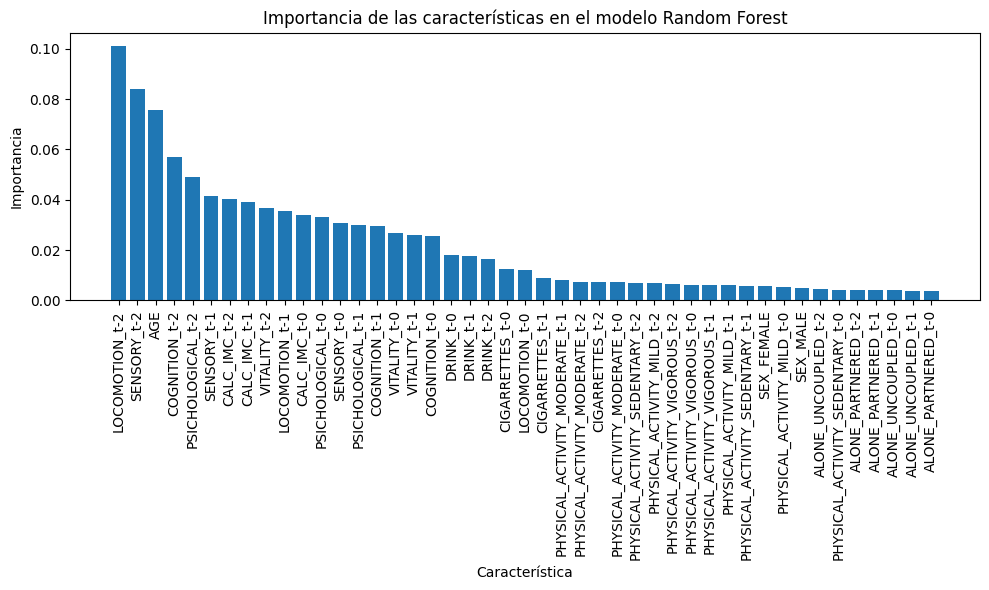

In [ ]:
!pip install scikit-learn
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam # Add this line to import the Adam
# Split data into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import mean_absolute_error # Import the mean_absolute_error function
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


%load_ext tensorboard

import os
log_dir = os.path.join("logs") # Puedes cambiar "logs" por el nombre que quieras
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Cargar los datos (suponiendo que están en un archivo CSV)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM.csv')

#ARREGLO PARA CALC_IMC NULL
data['CALC_IMC'] = data.groupby('ID')['CALC_IMC'].transform(lambda x: round(x.fillna(x.mean()), 0))
#eliminar filas con datos nulos en IMC
data = data.dropna(subset=['CALC_IMC'])

# Contar registros por ID, ignorando los NaN
#conteo_registros_por_persona = data.groupby('ID')['ID'].count()

# Personas con exactamente 4 registros (sin considerar NaN)
#personas_con_4_registros = conteo_registros_por_persona[conteo_registros_por_persona == 4]
#print(personas_con_4_registros)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv', index=False)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv')

# Normalize numerical variables
columns_to_scale = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION','CIGARRETTES','DRINK','CALC_IMC', 'AGE']
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[columns_to_scale])
#data[columns_to_scale] = scaled_data
data.loc[:, columns_to_scale] = scaled_data

# Convert categorical variables to one-hot encoding
# Crear un objeto OneHotEncoder
columns_to_transform = ['SEX','ALONE','PHYSICAL_ACTIVITY']
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(data[columns_to_transform])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_transform))
data = pd.concat([data, encoded_df], axis=1)

#data = data.drop(columns=['SEX','ALONE','PHYSICAL_ACTIVITY'])

# Agrupar por ID y ordenar por 'Evaluación'
#data_grouped = data.sort_values('evaluacion').groupby('ID')

#data = data.drop(columns=['ID','año','evaluación'])

#data.head()
#print(data.columns)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_ENCODED.csv', index=False)

# Definimos las columnas de las variables a predecir (target)
target_cols = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION']

# Prepare sequences and targets
def create_dataset(data, look_back=3):
  sequences = []
  targets = []
  locomotions = []
  sensories = []
  vitalities = []
  psichologicals = []
  cognitions = []
  auxiliares = []
  for person_id in data['ID'].unique():
    person_data = data[data['ID'] == person_id].sort_values('evaluacion')

     # Get the indices of the relevant columns
    relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY','PSICHOLOGICAL', 'COGNITION',
                        'ALONE_PARTNERED', 'ALONE_UNCOUPLED',
                        'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD','PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                        'CIGARRETTES','DRINK', 'CALC_IMC']
    auxiliar_columns = ['AGE','SEX_FEMALE', 'SEX_MALE']
     # Select the relevant columns first
    person_data_values = person_data[relevant_columns].values
    person_data_auxiliar = person_data[auxiliar_columns].values

    # Create sequences and targets
    if len(person_data_values) < look_back + 1:
        continue
    sequence = person_data_values[:look_back, :]
    target = person_data_values[look_back, data.columns.get_indexer(target_cols)]
    locomotion = person_data_values[look_back, 0]
    sensory = person_data_values[look_back, 1]
    vitality = person_data_values[look_back, 2]
    psichological = person_data_values[look_back, 3]
    cognition = person_data_values[look_back, 4]
    auxiliar = person_data_auxiliar[look_back, :]
    sequences.append(sequence)
    targets.append(target)
    locomotions.append(locomotion)
    sensories.append(sensory)
    vitalities.append(vitality)
    psichologicals.append(psichological)
    cognitions.append(cognition)
    auxiliares.append(auxiliar)
  return np.array(sequences), np.array(targets), np.array(locomotions), np.array(sensories), np.array(vitalities), np.array(psichologicals), np.array(cognitions), np.array(auxiliares)

# Create sequences and targets
look_back = 3
sequences, targets, locomotions, sensories, vitalities, psichologicals, cognitions, auxiliares = create_dataset(data, look_back)

pd.DataFrame(sequences[0]).head()
sequences.shape
sequences.shape[2]

sequences.shape[2]
#pd.DataFrame(targets[0]).head()

auxiliares.shape
auxiliares.shape[1]

targets.shape

# TRAINNING AND TEST

# Assuming 'sequences' and 'auxiliares' are your input features,
# and 'locomotions', 'sensories', etc. are your targets
# Split into 80% training and 20% testing
(
    sequences_train,
    sequences_test,
    auxiliares_train,
    auxiliares_test,
    locomotions_train,
    locomotions_test,
    sensories_train,
    sensories_test,
    vitalities_train,
    vitalities_test,
    psichologicals_train,
    psichologicals_test,
    cognitions_train,
    cognitions_test,
) = train_test_split(
    sequences,
    auxiliares,
    locomotions,
    sensories,
    vitalities,
    psichologicals,
    cognitions,
    test_size=0.2,
    random_state=42,  # Optional: for reproducibility
)


# Define input shapes
sequential_input_shape = (sequences.shape[1], sequences.shape[2])  # Adjust num_sequential_features
auxiliary_input_shape = (auxiliares.shape[1],)  # Adjust num_auxiliary_features

# Create the model
def create_model_rf():
    model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters
    return model

model = create_model_rf()

# Reshape and combine data for Random Forest
X_train = np.concatenate([sequences_train.reshape(sequences_train.shape[0], -1), auxiliares_train], axis=1)
X_test = np.concatenate([sequences_test.reshape(sequences_test.shape[0], -1), auxiliares_test], axis=1)
y_train = np.concatenate([locomotions_train[:, np.newaxis], sensories_train[:, np.newaxis],
                         vitalities_train[:, np.newaxis], psichologicals_train[:, np.newaxis],
                         cognitions_train[:, np.newaxis]], axis=1)
y_test = np.concatenate([locomotions_test[:, np.newaxis], sensories_test[:, np.newaxis],
                        vitalities_test[:, np.newaxis], psichologicals_test[:, np.newaxis],
                        cognitions_test[:, np.newaxis]], axis=1)

# Train the Random Forest model
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)


# Función para calcular MAE con intervalo de confianza usando Bootstrap (CÓDIGO NUEVO)
def calcular_intervalos_confianza(model, X_test, y_test, num_bootstrap_samples=1000):
    bootstrap_maes = []
    for _ in range(num_bootstrap_samples):
        X_test_resampled, y_test_resampled = resample(X_test, y_test, replace=True)
        predictions = model.predict(X_test_resampled)

     # Calculate MAE for each target and store them
        maes_for_this_bootstrap = [mean_absolute_error(y_test_resampled[:, i], predictions[:, i])
                                 for i in range(y_test.shape[1])]
        bootstrap_maes.append(maes_for_this_bootstrap)

    bootstrap_maes = np.array(bootstrap_maes)
    lower_percentile = 2.5  # For 95% CI
    upper_percentile = 97.5  # For 95% CI

    # Calculate CI directly for MAE values
    confidence_intervals = []
    for i in range(y_test.shape[1]):
        lower_bound = np.percentile(bootstrap_maes[:, i], lower_percentile)
        upper_bound = np.percentile(bootstrap_maes[:, i], upper_percentile)
        confidence_intervals.append((lower_bound, upper_bound))

    return confidence_intervals

confidence_intervals = calcular_intervalos_confianza(model, X_test, y_test)


# Define target names here
target_names = ['LOCOMOTION', 'SENSORY', 'VITALITY', 'PSICHOLOGICAL', 'COGNITION']

# --- Evaluation before Confidence Intervals ---
predictions = model.predict(X_test)  # Make predictions on the original test data

# --- Calculate Total Loss ---
total_loss = 0
for i in range(len(target_names)):
    loss_for_target = mean_absolute_error(y_test[:, i], predictions[:, i])
    total_loss += loss_for_target

total_loss /= len(target_names)  # Average the losses

print(f"Total Loss: {total_loss:.4f}")


# Print evaluation metrics (e.g., MAE)
for i in range(len(target_names)):
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    print(f"MAE for {target_names[i]}: {mae:.4f}")



# Calculate confidence intervals
confidence_intervals = calcular_intervalos_confianza(model, X_test, y_test)

# Make predictions using the trained SVM model
predictions = model.predict(X_test)

# Evaluate performance (including confidence intervals)
for i in range(len(target_names)):
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    lower_bound, upper_bound = confidence_intervals[i]
    print(f"MAE for {target_names[i]}: {mae:.4f} (95% CI: [{lower_bound:.4f}, {upper_bound:.4f}])")

# Obtén la importancia de las características
# Get feature names for sequences data
# Get feature names for sequences data
sequence_features = [f'sequence_{i}_{j}' for i in range(sequences_train.shape[1])
                     for j in range(sequences_train.shape[2])]

# --- Mapping to Original Names ---
relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY', 'PSICHOLOGICAL', 'COGNITION',
                       'ALONE_PARTNERED', 'ALONE_UNCOUPLED',
                       'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD',
                       'PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                       'CIGARRETTES', 'DRINK', 'CALC_IMC']
original_sequence_feature_names = []
for feature_name in sequence_features:
    parts = feature_name.split('_')  # Split the name into parts
    time_step = int(parts[1])  # Get the time step
    feature_index = int(parts[2])  # Get the feature index

    original_name = relevant_columns[feature_index]  # Get the original name from relevant_columns
    original_sequence_feature_names.append(f'{original_name}_t-{time_step}')  # Format the name (e.g., LOCOMOTION_t-0)


# Get feature names for auxiliares data
auxiliary_features = ['AGE', 'SEX_FEMALE', 'SEX_MALE']  # Replace with actual names if different

# Combine feature names
features = original_sequence_feature_names + auxiliary_features


importances = model.feature_importances_
# Crea un DataFrame para visualizar la importancia de las características
feature_importances = pd.DataFrame({'feature': features, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Crea un gráfico de barras para visualizar la importancia de las características
plt.figure(figsize=(10, 6))
plt.bar(feature_importances['feature'], feature_importances['importance'])
plt.xticks(rotation=90)
plt.xlabel('Característica')
plt.ylabel('Importancia')
plt.title('Importancia de las características en el modelo Random Forest')
plt.tight_layout()
plt.show()
